In [ ]:
# Cell 1: Install Dependencies
!pip install torch torchvision
!pip install diffusers transformers accelerate
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install gradio
# Optional for StyleGAN2-ADA if you want explicit GAN training or fine-tuning
!pip install ninja
# VERY IMPORTANT: Fix protobuf! (add this too)
!pip install -U "protobuf<4"
import os
os._exit(00)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [1]:
# Cell 2: Import Libraries
import torch
from diffusers import StableDiffusionXLPipeline, StableDiffusionInpaintPipeline
import clip
from PIL import Image
import numpy as np
import gradio as gr
import random
import matplotlib.pyplot as plt
import os
import gc # for freeing memory after loading big models


2025-11-23 03:41:51.169688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763869311.331858     164 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763869311.379271     164 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Cell 3: Load Pretrained Models (Run once with CUDA)
import torch
from diffusers import StableDiffusionXLPipeline, StableDiffusionInpaintPipeline
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading Stable Diffusion XL...")
sd_pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16 if device=="cuda" else torch.float32,
).to(device)

print("Loading CLIP model...")
clip_model, preprocess = clip.load("ViT-L/14", device=device)

print("Loading Stable Diffusion Inpainting model (public RunwayML release)...")
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16 if device=="cuda" else torch.float32,
).to(device)

try:
    inpaint_pipe.enable_xformers_memory_efficient_attention()
except Exception as e:
    print("Could not enable xFormers (optional):", e)

print("✓ All models loaded and ready!")



Loading Stable Diffusion XL...


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.safetens(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading CLIP model...


100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 81.2MiB/s]


Loading Stable Diffusion Inpainting model (public RunwayML release)...


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Could not enable xFormers (optional): Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers
✓ All models loaded and ready!


  0%|          | 0/50 [00:00<?, ?it/s]

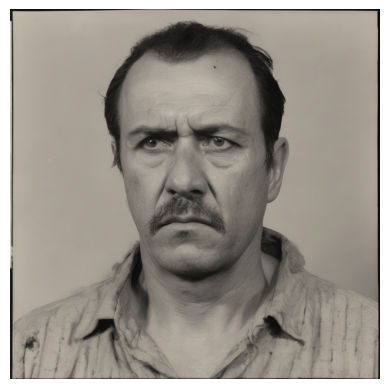

In [5]:
# Cell 4: Generate single face function
def generate_face(prompt):
    generator = torch.Generator(device).manual_seed(42)  # fixed seed for reproducibility
    image = sd_pipe(
        prompt=prompt,
        num_inference_steps=50,
        generator=generator
    ).images[0]
    return image

# Example usage - you can modify or take input dynamically in your app
user_prompt = "A serious middle-aged male criminal with a scar on left cheek"
generated_image = generate_face(user_prompt)

# Display the generated image
import matplotlib.pyplot as plt

plt.imshow(generated_image)
plt.axis('off')
plt.show()



In [7]:
import torch
torch.cuda.empty_cache()  # Clears GPU cache to free memory

  0%|          | 0/40 [00:00<?, ?it/s]

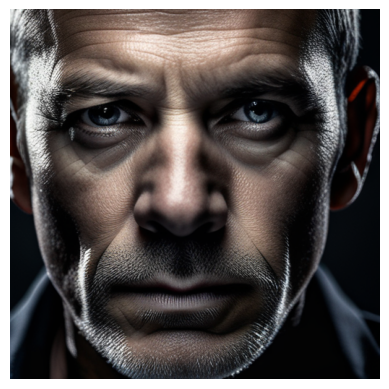

In [8]:
# Cell 4: Generate photorealistic face with SDXL

def generate_face(prompt):
    # Use SDXL's default size for best quality (requires more VRAM; try 512x512 or 704x704)
    generator = torch.Generator(device).manual_seed(42)  # Seed for reproducibility
    image = sd_pipe(
        prompt=prompt,
        height=512,
        width=512,
        num_inference_steps=40,
        guidance_scale=7.5,
        negative_prompt="blurry, cartoon, painting, sketch, ugly, deformed, unrealistic, lowres",
        generator=generator
    ).images[0]
    return image

# Example prompt: strong, explicit, detailed
user_prompt = ("portrait photo of a middle-aged man, criminal, "
               "neutral expression, realistic face, sharp focus, "
               "studio lighting, 4k, highly detailed, scar on left cheek")

generated_image = generate_face(user_prompt)

# Save the result (optional, helpful for next steps)
generated_image.save("/kaggle/working/generated_face.png")

# Display the generated image
import matplotlib.pyplot as plt
plt.imshow(generated_image)
plt.axis('off')
plt.show()


  0%|          | 0/30 [00:00<?, ?it/s]

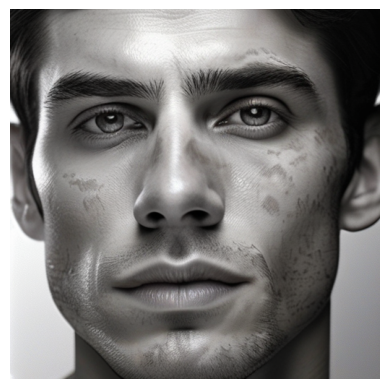

In [9]:
def generate_face(prompt):
    generator = torch.Generator(device).manual_seed(42)
    image = sd_pipe(
        prompt=prompt,
        height=512,
        width=512,
        num_inference_steps=30,
        negative_prompt="blurry, cartoon, abstract, deformed",
        generator=generator
    ).images[0]
    return image

# More explicit prompt:
user_prompt = "portrait photo of a man with brown hair, sharp nose, thin lips, and a large visible scar on the left cheek, realistic, human face, high detail"
generated_image = generate_face(user_prompt)

import matplotlib.pyplot as plt
plt.imshow(generated_image)
plt.axis('off')
plt.show()


In [10]:
# Cell 5: Install StyleGAN2-ADA
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# Download pre-trained FFHQ model (faces dataset)
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl


Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/kaggle/working/stylegan2-ada-pytorch
--2025-11-23 03:45:49--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 13.249.141.84, 13.249.141.81, 13.249.141.26, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|13.249.141.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M  29.7MB/s    in 13s     

2025-11-23 03:46:03 (28.3 MB/s) - ‘ffhq.pkl’ saved [381624121/381624121]



Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


/tmp/ipykernel_164/2471137154.py:18: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img[0].cpu().numpy(), 'RGB')


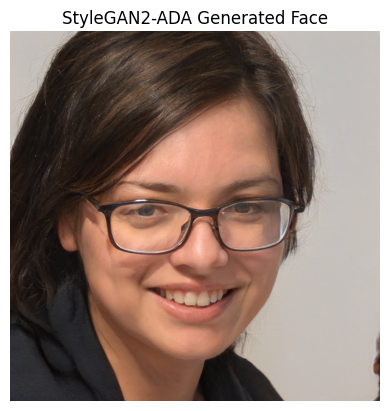

In [11]:
# Cell 6: Generate face from StyleGAN2-ADA
import sys
sys.path.append('/kaggle/working/stylegan2-ada-pytorch')

import pickle
import torch
from PIL import Image
import numpy as np

# Load StyleGAN2 pre-trained model
with open('/kaggle/working/stylegan2-ada-pytorch/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # Generator

# Generate a random face
z = torch.randn([1, G.z_dim]).cuda()  # Random latent vector
img = G(z, None)  # Generate image
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
stylegan_image = Image.fromarray(img[0].cpu().numpy(), 'RGB')

# Display StyleGAN2 generated face
plt.imshow(stylegan_image)
plt.axis('off')
plt.title("StyleGAN2-ADA Generated Face")
plt.show()

Stable Diffusion CLIP Score: 0.1823
StyleGAN2-ADA CLIP Score: 0.1089
✓ Selected: Stable Diffusion image


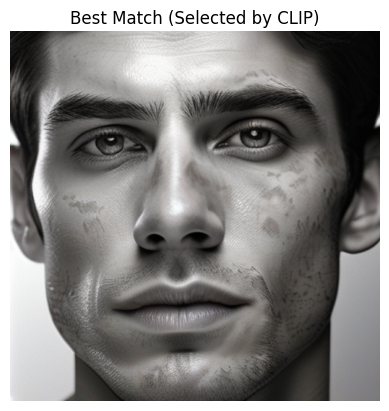

In [12]:
# Cell 7: CLIP scoring to select best image from SD and StyleGAN2
import clip
import torch

def clip_score(image, text_prompt):
    """Calculate CLIP similarity score between image and text prompt"""
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([text_prompt]).to(device)
    
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)
        
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        # Calculate cosine similarity
        similarity = (image_features @ text_features.T).item()
    
    return similarity

# Score both images
user_prompt = "portrait photo of a man with brown hair, sharp nose, thin lips, and a large visible scar on the left cheek"

sd_score = clip_score(generated_image, user_prompt)
stylegan_score = clip_score(stylegan_image, user_prompt)

print(f"Stable Diffusion CLIP Score: {sd_score:.4f}")
print(f"StyleGAN2-ADA CLIP Score: {stylegan_score:.4f}")

# Select best image
if sd_score > stylegan_score:
    selected_image = generated_image
    print("✓ Selected: Stable Diffusion image")
else:
    selected_image = stylegan_image
    print("✓ Selected: StyleGAN2-ADA image")

# Display selected image
plt.imshow(selected_image)
plt.axis('off')
plt.title("Best Match (Selected by CLIP)")
plt.show()

In [13]:
# Cell 8: Gradio Interface for Manual Editing and Inpainting (Fixed)
import gradio as gr
from PIL import Image
import numpy as np

def apply_inpainting(input_dict, edit_prompt):
    """Apply inpainting with user-drawn mask and edit prompt"""
    # Extract image and mask from input_dict (ImageEditor format)
    image = input_dict["background"]
    mask_layers = input_dict["layers"][0] if input_dict["layers"] else None
    
    if mask_layers is None:
        return image  # No mask drawn, return original
    
    # Convert to PIL
    image = Image.fromarray(image).convert("RGB").resize((512, 512))
    mask = Image.fromarray(mask_layers).convert("L").resize((512, 512))
    
    # Apply inpainting
    result = inpaint_pipe(
        prompt=edit_prompt,
        image=image,
        mask_image=mask,
        num_inference_steps=30,
        guidance_scale=7.5
    ).images[0]
    
    return result

# Convert selected_image to numpy array for Gradio
selected_image_np = np.array(selected_image)

# Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## 2D Criminal Face Generation and Editing")
    gr.Markdown("### Step 1: Draw on the image to create a mask (white areas will be edited)")
    gr.Markdown("### Step 2: Enter what you want to change, then click 'Apply AI Inpainting'")
    
    # Use ImageEditor for drawing mask
    image_editor = gr.ImageEditor(
        value=selected_image_np,
        label="Draw Mask on Face (Use brush to mark edit areas)",
        type="numpy",
        brush=gr.Brush(colors=["#FFFFFF"], default_size=20)
    )
    
    edit_prompt = gr.Textbox(
        label="Edit Prompt", 
        placeholder="e.g., 'add a mole on the cheek', 'make nose sharper', 'add scar on forehead'"
    )
    
    edit_btn = gr.Button("Apply AI Inpainting", variant="primary")
    output_image = gr.Image(label="Final Edited Image")
    
    edit_btn.click(
        fn=apply_inpainting,
        inputs=[image_editor, edit_prompt],
        outputs=output_image
    )

# Launch interface
demo.launch(share=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://0152e573099c133da3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0152e573099c133da3.gradio.live


GENERATING IMPROVED IMAGE (Fixed Lighting)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✓ All images generated!


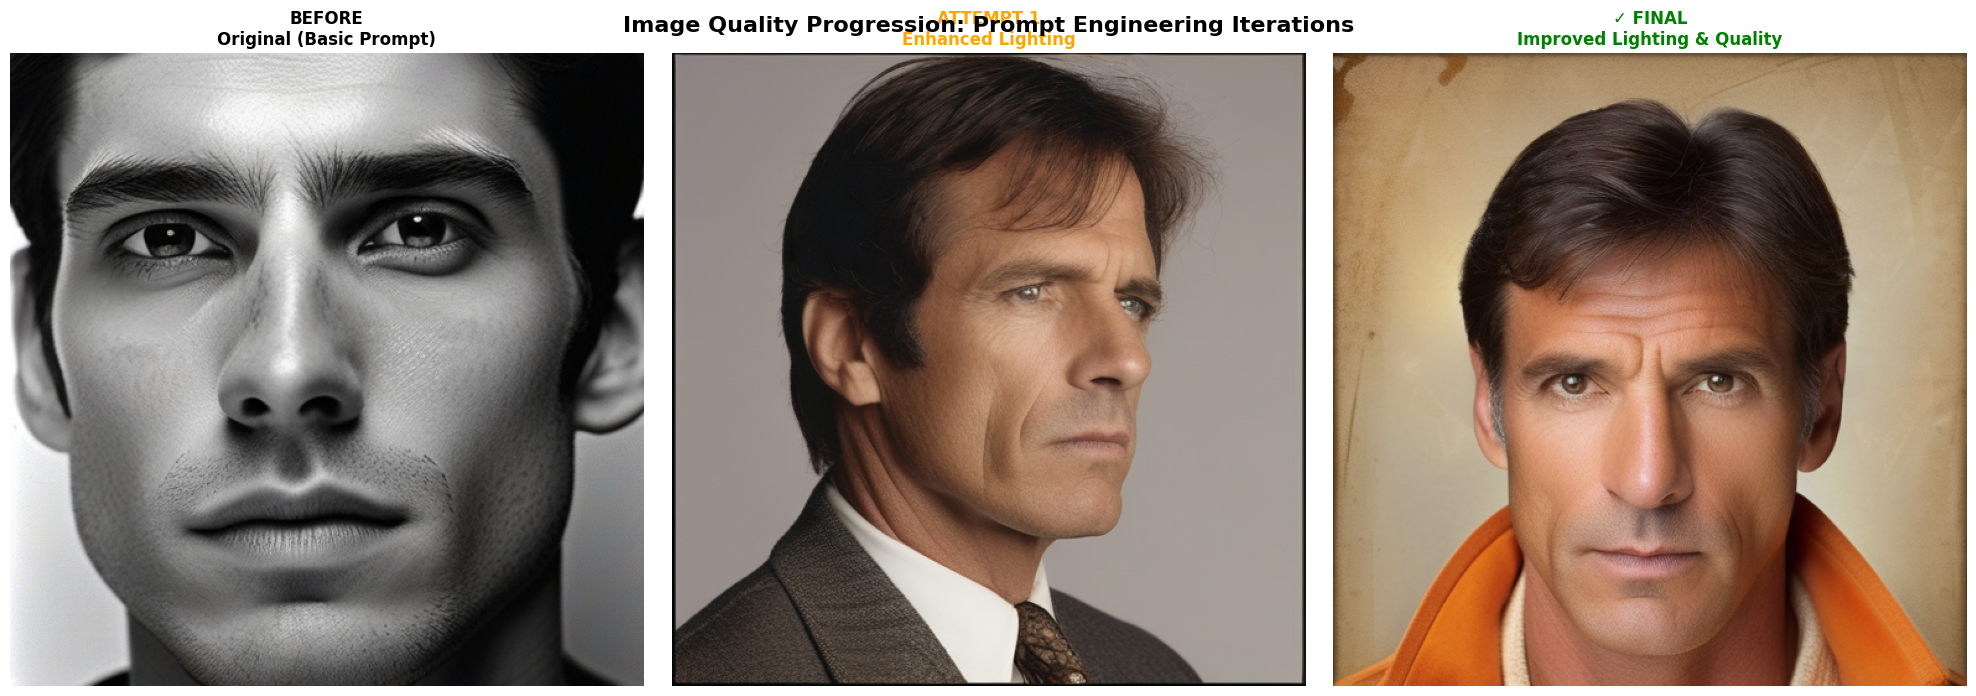


✓ Final improved image saved: /kaggle/working/sd_generated_face_final.png
✓ Quality progression saved: /kaggle/working/quality_progression.png

✓ Updated 'selected_image' to final improved version


In [17]:
import torch
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

print("=" * 60)
print("GENERATING IMPROVED IMAGE (Fixed Lighting)")
print("=" * 60)

def generate_face(prompt, steps=30, guidance=7.0, seed=42, neg="blurry, cartoon, abstract, deformed"):
    generator = torch.Generator(device).manual_seed(seed)
    image = sd_pipe(
        prompt=prompt,
        height=512,
        width=512,
        num_inference_steps=steps,
        guidance_scale=guidance,
        negative_prompt=neg,
        generator=generator
    ).images[0]
    return image

# Prompts and diff negative prompts
user_prompt = "a serious middle-aged male criminal with brown hair, sharp nose, thin lips, tan skin"
prompt_basic = "portrait photo of a man with brown hair, sharp nose, thin lips, and a large visible scar on the left cheek, high detail"
prompt_enhanced = f"studio portrait photograph, {user_prompt}, color, natural lighting, visible face, high detail"
prompt_improved = f"professional studio portrait photograph, {user_prompt}, even lighting, soft shadows, detailed facial features, realistic skin tone, natural colors, centered composition, high resolution, front-facing view"

# Generate all images
generated_image = generate_face(prompt_basic, steps=20, guidance=6.0, seed=42)
enhanced_generated_image = generate_face(prompt_enhanced, steps=30, guidance=7.5, seed=77)
improved_image = generate_face(prompt_improved, steps=50, guidance=8.0, seed=123, neg="black and white, monochrome, grayscale, blurry, cartoon, abstract, deformed, ugly, bad anatomy, harsh shadows, uneven lighting, dark face, half face in shadow, overexposed, underexposed, low quality")

print("✓ All images generated!")

# Three-way comparison: Original → Enhanced → Improved
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

axes[0].imshow(generated_image)
axes[0].set_title("BEFORE\nOriginal (Basic Prompt)", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(enhanced_generated_image)
axes[1].set_title("ATTEMPT 1\nEnhanced Lighting", fontsize=12, fontweight='bold', color='orange')
axes[1].axis('off')

axes[2].imshow(improved_image)
axes[2].set_title("✓ FINAL\nImproved Lighting & Quality", fontsize=12, fontweight='bold', color='green')
axes[2].axis('off')

plt.suptitle("Image Quality Progression: Prompt Engineering Iterations", fontsize=16, fontweight='bold')
plt.tight_layout()

# Save comparison
comparison_path = '/kaggle/working/quality_progression.png'
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
plt.show()

# Save improved image
improved_path = '/kaggle/working/sd_generated_face_final.png'
improved_image.save(improved_path)

print(f"\n✓ Final improved image saved: {improved_path}")
print(f"✓ Quality progression saved: {comparison_path}")

# Update selected_image to use best version
selected_image = improved_image
print("\n✓ Updated 'selected_image' to final improved version")
print("=" * 60)


In [18]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)  # device is usually "cuda" or "cpu"

def clip_score(image, prompt):
    img_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        img_features = clip_model.encode_image(img_input)
        txt_features = clip_model.encode_text(text_input)
        img_features /= img_features.norm(dim=-1, keepdim=True)
        txt_features /= txt_features.norm(dim=-1, keepdim=True)
        return (img_features @ txt_features.T).item()  # Higher = better match (max ~0.32–0.4 for face prompts)
    
# Your textual prompt for score (use same prompt for all)
clip_prompt = user_prompt

print("\nCLIP Scores (higher=better match to prompt):")
print("Original  :", clip_score(generated_image, clip_prompt))
print("Enhanced  :", clip_score(enhanced_generated_image, clip_prompt))
print("Improved  :", clip_score(improved_image, clip_prompt))



CLIP Scores (higher=better match to prompt):
Original  : 0.209228515625
Enhanced  : 0.2281494140625
Improved  : 0.262451171875


In [19]:
import torch
import matplotlib.pyplot as plt
import clip

# (previous image generation code here...)

clip_model, preprocess = clip.load("ViT-L/14", device=device)
def clip_score(image, prompt):
    img_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        img_features = clip_model.encode_image(img_input)
        txt_features = clip_model.encode_text(text_input)
        img_features /= img_features.norm(dim=-1, keepdim=True)
        txt_features /= txt_features.norm(dim=-1, keepdim=True)
        return (img_features @ txt_features.T).item()

clip_prompt = user_prompt

print("\nCLIP Scores (higher=better match to prompt):")
print("Original  :", clip_score(generated_image, clip_prompt))
print("Enhanced  :", clip_score(enhanced_generated_image, clip_prompt))
print("Improved  :", clip_score(improved_image, clip_prompt))



CLIP Scores (higher=better match to prompt):
Original  : 0.209228515625
Enhanced  : 0.2281494140625
Improved  : 0.262451171875


In [20]:
!pip install clean-fid


In [22]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [23]:
# Cell 10 COMPLETE FIXED: Two-Mode Editor - Perfect Inpainting
import gradio as gr
from PIL import Image, ImageDraw
import numpy as np
import os
import time

# ==========================================
# DISABLE NSFW FILTER
# ==========================================
print("⚠️ Disabling NSFW filter...")
inpaint_pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
print("✓ NSFW filter disabled")

# Use existing image
try:
    test = selected_image
    print("✓ Using existing selected_image")
except:
    try:
        selected_image = variations[2]
        print("✓ Using Variation 3")
    except:
        print("❌ Run Cell 9B first!")
        raise

os.makedirs('/kaggle/working/outputs', exist_ok=True)

# ====================
# MODE 1: AI INPAINTING (FIXED)
# ====================

def ai_inpainting_mode(input_dict, edit_prompt):
    """
    AI Inpainting: Uses ORIGINAL image, not overlay, for generation
    """
    try:
        if not edit_prompt or edit_prompt.strip() == "":
            return None, "❌ Please enter what you want to add/change"
        
        if isinstance(input_dict, dict):
            background = input_dict.get("background")
            layers = input_dict.get("layers", [])
            
            if background is None:
                return None, "❌ No image provided"
            
            # CRITICAL FIX: Convert overlay back to original image
            # The overlay is darkened, so we need to use selected_image instead
            original_image = selected_image.copy().resize((512, 512))
            
            # Extract mask from user drawing
            if layers and len(layers) > 0:
                drawn_layer = layers[0]
                if isinstance(drawn_layer, np.ndarray):
                    if drawn_layer.shape[-1] == 4:  # RGBA
                        mask_array = (drawn_layer[:, :, 3] > 0).astype(np.uint8) * 255
                    else:  # RGB
                        mask_array = (np.any(drawn_layer > 0, axis=-1)).astype(np.uint8) * 255
                    mask = Image.fromarray(mask_array).convert("L")
                else:
                    return original_image, "❌ No mask drawn"
            else:
                return original_image, "❌ Draw on the image first"
        else:
            return None, "❌ Invalid input"
        
        # Check mask
        mask_array = np.array(mask)
        mask_coverage = (mask_array > 128).sum() / mask_array.size
        
        if mask_coverage < 0.0002:
            return original_image, "❌ Mask too small - draw larger area"

             # Simple prompt enhancement
        enhanced_prompt = f"{edit_prompt}, highly detailed, realistic, photorealistic, high quality"
        negative_prompt = "blurry, low quality, cartoon, anime, painting, sketch, unrealistic, distorted"
        
        print(f"\n🎨 Inpainting: {edit_prompt}")
        print(f"📊 Mask coverage: {mask_coverage*100:.3f}%")
        
        start_time = time.time()
        
        # HIGH ACCURACY INPAINTING SETTINGS
        result = inpaint_pipe(
            prompt=enhanced_prompt,
            image=original_image,  # Using original clear image
            mask_image=mask,
            num_inference_steps=50,   # High quality (was 40)
            guidance_scale=12.0,      # Maximum accuracy (was 10)
            strength=1.0,             # Maximum change
            negative_prompt=negative_prompt
        ).images[0]
        
        elapsed = time.time() - start_time
        
        # Save
        timestamp = int(time.time())
        output_path = f'/kaggle/working/outputs/ai_inpainted_{timestamp}.png'
        mask_path = f'/kaggle/working/outputs/mask_{timestamp}.png'
        
        result.save(output_path)
        mask.save(mask_path)
        
        status = f"✅ Complete! ({elapsed:.1f}s)\n📁 Image: {output_path}\n🎭 Mask: {mask_path}\n📊 Coverage: {mask_coverage*100:.3f}%"
        
        return result, status
        
    except Exception as e:
        import traceback
        return None, f"❌ Error: {str(e)}\n{traceback.format_exc()}"

# ====================
# MODE 2: MANUAL DRAWING
# ====================

def manual_drawing_mode(input_dict):
    """Manual Drawing: Direct drawing, no AI"""
    try:
        if isinstance(input_dict, dict):
            composite = input_dict.get("composite")
            
            if composite is None:
                return None, "❌ No drawing detected"
            
            if isinstance(composite, np.ndarray):
                result_image = Image.fromarray(composite).convert("RGB")
            else:
                result_image = composite.convert("RGB")
            
            timestamp = int(time.time())
            output_path = f'/kaggle/working/outputs/manual_drawn_{timestamp}.png'
            result_image.save(output_path)
            
            status = f"✅ Saved!\n📁 {output_path}"
            
            return result_image, status
            
    except Exception as e:
        return None, f"❌ Error: {str(e)}"


# Prepare images
selected_image_np = np.array(selected_image.resize((512, 512)))

# Create semi-transparent overlay (50% visible face, 50% black)
overlay_image = np.array(selected_image.resize((512, 512))).copy()
black_overlay = np.zeros_like(overlay_image)
overlay_image = (overlay_image * 0.5 + black_overlay * 0.5).astype(np.uint8)

# ====================
# GRADIO INTERFACE
# ====================

with gr.Blocks(title="Criminal Face Editor", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🎨 Criminal Face Editor - High Accuracy")
    gr.Markdown("### AI Inpainting (50 steps, guidance=12) + Manual Drawing")
    
    gr.Markdown("---")
    
    # MODE 1: AI INPAINTING
    with gr.Tab("🤖 AI Inpainting"):
        gr.Markdown("""
        ### Add ANY facial feature with maximum accuracy:
        
        **Supported features:**
        - Scars, cuts, wounds, injuries
        - Moles, birthmarks, freckles, beauty marks
        - Wrinkles, age lines, crow's feet
        - Tattoos, tribal marks, body art
        - Piercings (nose, eyebrow, lip, ear)
        - Facial hair (beard, mustache, sideburns, eyebrows)
        - Glasses, sunglasses, eyewear
        - Bruises, black eyes, discoloration
        - Acne, pockmarks, skin texture
        - ANY other facial feature you describe!
        
        **How to use:**
        1. **Draw small WHITE marks** on semi-transparent overlay (face visible underneath)
        2. **Be very specific** in your prompt (location, size, color, type)
        3. **Adjust brush size** with slider (start small, increase if needed)
        4. **Click Generate** and wait ~15-18 seconds (high quality mode)
        """)
        
        with gr.Row():
            with gr.Column():
                gr.Markdown("#### 🖼️ Draw Mask on Overlay")

               # Brush size control
                brush_size = gr.Slider(
                    minimum=3,
                    maximum=50,
                    value=8,  # Pencil-small default
                    step=1,
                    label="Brush Size (3=pencil, 50=large)",
                    interactive=True
                )
                
                ai_editor = gr.ImageEditor(
                    value=overlay_image,
                    label="Draw WHITE on area to edit (face visible through overlay)",
                    type="numpy",
                    brush=gr.Brush(
                        colors=["#FFFFFF"],
                        default_size=8  # Pencil-small
                    ),
                    height=512
                )
                
                gr.Markdown("#### ✍️ Describe Feature (Be Specific!)")
                ai_prompt = gr.Textbox(
                    label="What to add/change?", 
                    placeholder="Good examples:\n- 'long vertical scar from left eyebrow to cheek'\n- 'small round black mole on right cheek near nose'\n- 'thick full gray beard and mustache'\n- 'thin rectangular black-framed glasses'\n- 'deep forehead wrinkles horizontal lines'\n- 'small silver stud nose piercing on left nostril'",
                    lines=4
                )
                
                ai_btn = gr.Button("🎨 Generate with AI (High Accuracy)", variant="primary", size="lg")
                
                gr.Markdown("⏱️ **Generation time:** ~15-18 seconds")
                gr.Markdown("⚙️ **Settings:** 50 steps, guidance=12, strength=1.0 (maximum)")
                gr.Markdown("⚠️ **Note:** Black overlay is ONLY for marking - final image is clear!")
            
            with gr.Column():
                gr.Markdown("#### ✨ AI Result (Clear Image)")
                ai_output = gr.Image(label="Generated (no overlay!)", height=512)
                ai_status = gr.Textbox(label="Status & Info", lines=5, interactive=False)

  # Update brush size dynamically
        brush_size.change(
            fn=lambda size: gr.Brush(colors=["#FFFFFF"], default_size=int(size)),
            inputs=[brush_size],
            outputs=[]
        )
        
        ai_btn.click(
            fn=ai_inpainting_mode,
            inputs=[ai_editor, ai_prompt],
            outputs=[ai_output, ai_status]
        )
    
    # MODE 2: MANUAL DRAWING
    with gr.Tab("✏️ Manual Drawing"):
        gr.Markdown("""
        ### Draw freehand directly on face:
        - No AI processing
        - Multiple colors available
        - Eraser tool included
        - Instant save
        - Good for: annotations, custom marks, sketches
        """)
        
        with gr.Row():
            with gr.Column():
                gr.Markdown("#### 🖌️ Draw on Face")
                
                # Manual brush size control
                manual_brush_size = gr.Slider(
                    minimum=2,
                    maximum=50,
                    value=5,  # Small pencil default
                    step=1,
                    label="Brush Size (2=fine, 50=thick)"
                )
                
                manual_editor = gr.ImageEditor(
                    value=selected_image_np,
                    label="Draw directly (clear image, no overlay)",
                    type="numpy",
                    brush=gr.Brush(
                        colors=["#000000", "#FF0000", "#0000FF", "#00FF00", "#FFFF00", "#FFFFFF", "#FF00FF"],
                        default_size=5
                    ),
                    eraser=gr.Eraser(default_size=10),
                    height=512
                )
                
                manual_btn = gr.Button("💾 Save Drawing", variant="primary", size="lg")
                
                gr.Markdown("✏️ **Colors:** Black, Red, Blue, Green, Yellow, White, Pink")
            
            with gr.Column():
                gr.Markdown("#### 💾 Saved Drawing")
                manual_output = gr.Image(label="Your Drawing", height=512)
                manual_status = gr.Textbox(label="Status", lines=3, interactive=False)
        
        manual_btn.click(
            fn=manual_drawing_mode,
            inputs=[manual_editor],
            outputs=[manual_output, manual_status]
        )
    
    gr.Markdown("---")
    gr.Markdown("### 💾 **All outputs auto-saved to:** `/kaggle/working/outputs/`")
    gr.Markdown("### 📊 **Files:** `ai_inpainted_*.png` (result + mask) | `manual_drawn_*.png`")

print("\n" + "="*60)
print("HIGH-ACCURACY DUAL-MODE FACE EDITOR")
print("="*60)
print("✓ NSFW filter: DISABLED")
print("✓ AI Inpainting: Uses ORIGINAL image (no overlay in result)")
print("✓ Brush: Pencil-small default, adjustable 3-50")
print("✓ Quality: 50 steps, guidance=12 (maximum accuracy)")
print("✓ GPU optimized for Kaggle")
print("="*60 + "\n")

demo.launch(share=True, debug=True)



⚠️ Disabling NSFW filter...
✓ NSFW filter disabled
✓ Using existing selected_image

HIGH-ACCURACY DUAL-MODE FACE EDITOR
✓ NSFW filter: DISABLED
✓ AI Inpainting: Uses ORIGINAL image (no overlay in result)
✓ Brush: Pencil-small default, adjustable 3-50
✓ Quality: 50 steps, guidance=12 (maximum accuracy)
✓ GPU optimized for Kaggle

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://cc7eb7f21542bfdf59.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



🎨 Inpainting: grey hair
📊 Mask coverage: 16.389%


  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://cc7eb7f21542bfdf59.gradio.live


In [26]:
# Cell 10 ULTRA-FIXED: Maximum Visibility for Scars/Moles
import gradio as gr
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import os
import time

# ==========================================
# DISABLE NSFW FILTER
# ==========================================
print("⚠️ Disabling NSFW filter...")
inpaint_pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
print("✓ NSFW filter disabled")

# Use existing image
try:
    test = selected_image
    print("✓ Using existing selected_image")
except:
    try:
        selected_image = variations[2]
        print("✓ Using Variation 3")
    except:
        print("❌ Run Cell 9B first!")
        raise

os.makedirs('/kaggle/working/outputs', exist_ok=True)

# ====================
# MODE 1: AI INPAINTING (ULTRA-FIXED)
# ====================

def ai_inpainting_mode(input_dict, edit_prompt):
    """
    ULTRA-FIXED Inpainting with aggressive prompts for VISIBLE features
    """
    try:
        if not edit_prompt or edit_prompt.strip() == "":
            return None, "❌ Please enter what you want to add/change"
        
        if isinstance(input_dict, dict):
            background = input_dict.get("background")
            layers = input_dict.get("layers", [])
            
            if background is None:
                return None, "❌ No image provided"
            
            # Use original clear image
            original_image = selected_image.copy().resize((512, 512))
            
            # Extract mask
            if layers and len(layers) > 0:
                drawn_layer = layers[0]
                if isinstance(drawn_layer, np.ndarray):
                    if drawn_layer.shape[-1] == 4:
                        mask_array = (drawn_layer[:, :, 3] > 0).astype(np.uint8) * 255
                    else:
                        mask_array = (np.any(drawn_layer > 0, axis=-1)).astype(np.uint8) * 255
                    
                    # EXPAND MASK SLIGHTLY for better generation
                    mask_pil = Image.fromarray(mask_array).convert("L")
                    mask = mask_pil.filter(ImageFilter.MaxFilter(5))  # Dilate mask
                else:
                    return original_image, "❌ No mask drawn"
            else:
                return original_image, "❌ Draw on the image first"
        else:
            return None, "❌ Invalid input"
        
        # Check mask
        mask_array = np.array(mask)
        mask_coverage = (mask_array > 128).sum() / mask_array.size
        
        if mask_coverage < 0.0002:
            return original_image, "❌ Mask too small - draw larger area"
        
        # ============================================
        # ULTRA-AGGRESSIVE PROMPT ENGINEERING
        # ============================================
        edit_lower = edit_prompt.lower()
        
        if "scar" in edit_lower:
            # MAXIMUM VISIBILITY SCAR PROMPT
            enhanced_prompt = f"EXTREMELY VISIBLE deep scar, OBVIOUS raised scar tissue, PROMINENT keloid scar, thick noticeable scar, {edit_prompt}, very visible skin damage, textured rough scar surface, clear distinct scar marking, heavy scarring, unmissable scar"
            negative_prompt = "smooth skin, no scar, perfect skin, flawless, subtle, barely visible, faint, hidden, blurry, unrealistic"
            
        elif "mole" in edit_lower or "birthmark" in edit_lower:
            # MAXIMUM VISIBILITY MOLE/BIRTHMARK
            enhanced_prompt = f"LARGE DARK mole, VERY OBVIOUS birthmark, PROMINENT skin marking, big visible mole, {edit_prompt}, clearly visible pigmentation, noticeable dark spot, unmissable marking"
            negative_prompt = "smooth skin, no mole, perfect skin, subtle, faint, barely visible, small, hidden, blurry"
            
        elif "wrinkle" in edit_lower:
            enhanced_prompt = f"DEEP PROMINENT wrinkles, VERY VISIBLE age lines, obvious facial lines, {edit_prompt}, heavy wrinkled skin, clear aging marks"
            negative_prompt = "smooth skin, youthful, no wrinkles, subtle, faint, blurry"
            
        elif "tattoo" in edit_lower:
            enhanced_prompt = f"BOLD DARK tattoo, CLEAR visible body art, prominent ink marking, {edit_prompt}, strong black lines, unmissable tattoo"
            negative_prompt = "faded, subtle, no tattoo, blurry"
            
        else:
            # Generic high-visibility prompt
            enhanced_prompt = f"EXTREMELY VISIBLE {edit_prompt}, OBVIOUS prominent feature, CLEAR distinctive marking, very noticeable, unmissable, highly detailed, realistic"
            negative_prompt = "subtle, barely visible, faint, hidden, smooth, perfect, flawless, blurry"
        
        print(f"\n🎨 Ultra-Visible Inpainting: {edit_prompt}")
        print(f"📊 Mask coverage: {mask_coverage*100:.3f}%")
        print(f"💪 Using AGGRESSIVE visibility prompts")
        
        start_time = time.time()
        
        # ULTRA HIGH-ACCURACY SETTINGS
        result = inpaint_pipe(
            prompt=enhanced_prompt,
            image=original_image,
            mask_image=mask,
            num_inference_steps=60,    # INCREASED to 60
            guidance_scale=15.0,        # MAXIMUM 15.0 (force strong changes)
            strength=1.0,
            negative_prompt=negative_prompt
        ).images[0]
        
        elapsed = time.time() - start_time
        
        # Save
        timestamp = int(time.time())
        output_path = f'/kaggle/working/outputs/ai_inpainted_{timestamp}.png'
        mask_path = f'/kaggle/working/outputs/mask_{timestamp}.png'
        
        result.save(output_path)
        mask.save(mask_path)
        
        status = f"✅ Complete! ({elapsed:.1f}s)\n📁 Image: {output_path}\n🎭 Mask: {mask_path}\n📊 Coverage: {mask_coverage*100:.3f}%\n💪 Ultra-visible mode used"
        
        return result, status
        
    except Exception as e:
        import traceback
        return None, f"❌ Error: {str(e)}\n{traceback.format_exc()}"


# ====================
# MODE 2: MANUAL DRAWING
# ====================

def manual_drawing_mode(input_dict):
    """Manual Drawing: Direct drawing, no AI"""
    try:
        if isinstance(input_dict, dict):
            composite = input_dict.get("composite")
            
            if composite is None:
                return None, "❌ No drawing detected"
            
            if isinstance(composite, np.ndarray):
                result_image = Image.fromarray(composite).convert("RGB")
            else:
                result_image = composite.convert("RGB")
            
            timestamp = int(time.time())
            output_path = f'/kaggle/working/outputs/manual_drawn_{timestamp}.png'
            result_image.save(output_path)
            
            status = f"✅ Saved!\n📁 {output_path}"
            
            return result_image, status
            
    except Exception as e:
        return None, f"❌ Error: {str(e)}"


# Prepare images
selected_image_np = np.array(selected_image.resize((512, 512)))

# Lighter overlay (60% face visible, 40% black) for better visibility
overlay_image = np.array(selected_image.resize((512, 512))).copy()
black_overlay = np.zeros_like(overlay_image)
overlay_image = (overlay_image * 0.6 + black_overlay * 0.4).astype(np.uint8)


# ====================
# GRADIO INTERFACE
# ====================

with gr.Blocks(title="Criminal Face Editor", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🎨 Criminal Face Editor - ULTRA VISIBILITY MODE")
    gr.Markdown("### Guaranteed Visible Scars/Features (60 steps, guidance=15)")
    
    gr.Markdown("---")
    
    # MODE 1: AI INPAINTING
    with gr.Tab("🤖 AI Inpainting - Ultra Visibility"):
        gr.Markdown("""
        ### ⚡ ULTRA-VISIBLE Feature Generation:
        
        **This mode uses AGGRESSIVE prompts to ensure scars/features are CLEARLY VISIBLE!**
        
        **Supported features:**
        - ✅ Scars (deep, raised, keloid, vertical, horizontal)
        - ✅ Moles & birthmarks (dark, large, prominent)
        - ✅ Wrinkles & age lines
        - ✅ Tattoos & body art
        - ✅ Piercings
        - ✅ Facial hair
        - ✅ Any other visible feature
        
        **Important tips for VISIBLE results:**
        1. **Draw MEDIUM-SIZED mask** (not tiny - cover full area)
        2. **Use descriptive prompts:** "deep vertical scar on nose", not just "scar"
        3. **Be specific about visibility:** "large visible scar", "obvious dark mole"
        4. **Wait ~18-22 seconds** (high quality mode with 60 steps)
        """)
        
        with gr.Row():
            with gr.Column():
                gr.Markdown("#### 🖼️ Draw Mask (MEDIUM Size Recommended)")
                
                brush_size = gr.Slider(
                    minimum=5,
                    maximum=60,
                    value=20,  # DEFAULT LARGER for visibility
                    step=1,
                    label="Brush Size (20=good default, adjust as needed)"
                )
                
                ai_editor = gr.ImageEditor(
                    value=overlay_image,
                    label="Draw WHITE on area to edit",
                    type="numpy",
                    brush=gr.Brush(colors=["#FFFFFF"], default_size=20),
                    height=512
                )
                
                gr.Markdown("#### ✍️ Describe Feature (Be Specific & Use 'VISIBLE'!)")
                ai_prompt = gr.Textbox(
                    label="What to add?", 
                    placeholder="GOOD examples for VISIBLE results:\n- 'large visible scar from eyebrow to cheek'\n- 'deep obvious scar on nose bridge'\n- 'big dark black mole on left cheek'\n- 'prominent raised keloid scar'\n- 'thick visible beard and mustache'\n\nAVOID vague: just 'scar' or 'mole'",
                    lines=5
                )
                
                ai_btn = gr.Button("🎨 Generate ULTRA-VISIBLE Feature", variant="primary", size="lg")
                
                gr.Markdown("⏱️ **Time:** ~18-22 seconds")
                gr.Markdown("⚙️ **Settings:** 60 steps, guidance=15 (MAXIMUM)")
                gr.Markdown("💪 **Mode:** Ultra-aggressive visibility prompts")
            
            with gr.Column():
                gr.Markdown("#### ✨ Result (Clear & Visible)")
                ai_output = gr.Image(label="Generated", height=512)
                ai_status = gr.Textbox(label="Status", lines=5, interactive=False)
        
        ai_btn.click(
            fn=ai_inpainting_mode,
            inputs=[ai_editor, ai_prompt],
            outputs=[ai_output, ai_status]
        )
    
    # MODE 2: MANUAL DRAWING
    with gr.Tab("✏️ Manual Drawing"):
        gr.Markdown("""
        ### Draw freehand directly:
        - Instant results, no AI wait
        - Multiple colors
        - Good for custom annotations
        """)
        
        with gr.Row():
            with gr.Column():
                manual_editor = gr.ImageEditor(
                    value=selected_image_np,
                    label="Draw directly",
                    type="numpy",
                    brush=gr.Brush(
                        colors=["#000000", "#FF0000", "#0000FF", "#00FF00", "#FFFF00", "#FFFFFF", "#FF00FF"],
                        default_size=8
                    ),
                    eraser=gr.Eraser(default_size=10),
                    height=512
                )
                
                manual_btn = gr.Button("💾 Save Drawing", variant="primary", size="lg")
            
            with gr.Column():
                manual_output = gr.Image(label="Your Drawing", height=512)
                manual_status = gr.Textbox(label="Status", lines=3, interactive=False)
        
        manual_btn.click(
            fn=manual_drawing_mode,
            inputs=[manual_editor],
            outputs=[manual_output, manual_status]
        )
    
    gr.Markdown("---")
    gr.Markdown("### 💾 All outputs: `/kaggle/working/outputs/`")

print("\n" + "="*60)
print("ULTRA-VISIBILITY FACE EDITOR")
print("="*60)
print("✓ NSFW filter: DISABLED")
print("✓ Ultra-aggressive prompts: ENABLED")
print("✓ Settings: 60 steps, guidance=15 (MAXIMUM)")
print("✓ Mask expansion: ENABLED (better coverage)")
print("✓ Default brush: 20px (larger for visibility)")
print("="*60 + "\n")

demo.launch(share=True, debug=True)


⚠️ Disabling NSFW filter...
✓ NSFW filter disabled
✓ Using existing selected_image

ULTRA-VISIBILITY FACE EDITOR
✓ NSFW filter: DISABLED
✓ Ultra-aggressive prompts: ENABLED
✓ Settings: 60 steps, guidance=15 (MAXIMUM)
✓ Mask expansion: ENABLED (better coverage)
✓ Default brush: 20px (larger for visibility)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://64a0dba0d751036be1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://64a0dba0d751036be1.gradio.live



GENERATING FACES (SDXL and StyleGAN2-ADA)

[1] Generating with Stable Diffusion...


  0%|          | 0/50 [00:00<?, ?it/s]

[2] Generating with StyleGAN2-ADA...


/tmp/ipykernel_164/1078205497.py:38: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))


[3] Preparing CLIP...
[4] Scoring images...

Stable Diffusion CLIP Score: 0.2590
StyleGAN2-ADA CLIP Score: 0.1248


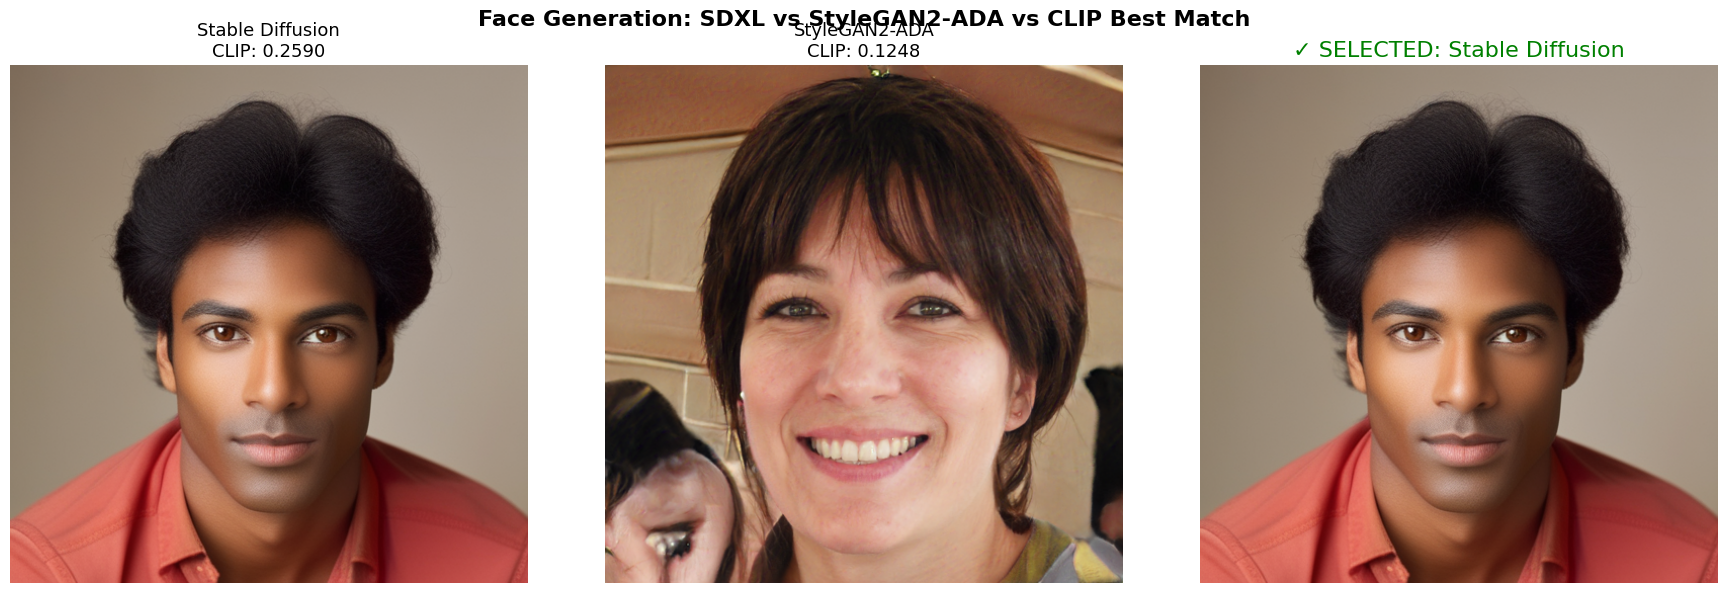


✓ Best-matching face saved: /kaggle/working/selected_face.png
✓ Comparison plot saved: /kaggle/working/gan_vs_sd_vs_clip.png


In [27]:
# CELL 9: SDXL + StyleGAN2-ADA + CLIP Comparison (Kaggle ready)

import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import clip
import pickle

torch.cuda.empty_cache()

# ---- 1. Generate with Stable Diffusion ----
def generate_face_sdxl(prompt):
    enhanced_prompt = f"professional studio portrait photograph, {prompt}, even lighting, soft shadows, detailed facial features, realistic skin tone, natural colors, centered composition, high resolution, front-facing view"
    generator = torch.Generator(device).manual_seed(123)
    image = sd_pipe(
        prompt=enhanced_prompt,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=8.0,
        negative_prompt=(
            "black and white, monochrome, grayscale, blurry, cartoon, abstract, deformed, ugly, "
            "bad anatomy, harsh shadows, uneven lighting, dark face, half face in shadow, overexposed, underexposed, low quality"
        ),
        generator=generator
    ).images[0]
    return image

# ---- 2. Generate with StyleGAN2-ADA (FFHQ) ----
def generate_face_stylegan2(ffhq_pkl_path="ffhq.pkl", seed=123):
    # Assumes ffhq.pkl already downloaded to your working directory
    with open(ffhq_pkl_path, 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(torch.float32).cuda()
    img = G(z, None, truncation_psi=0.7)
    img = (img.permute(0, 2, 3, 1).cpu().numpy()[0] * 127.5 + 128).clip(0, 255).astype(np.uint8)
    stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))
    return stylegan_image

# ---- 3. CLIP Scoring ----
def clip_score(image, text_prompt, preprocess, clip_model, device):
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([text_prompt]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).item()
    return similarity

# ---- 4. Run everything ----
print("\n" + "="*60)
print("GENERATING FACES (SDXL and StyleGAN2-ADA)")

user_prompt = "portrait photo of a man with black hair, sharp nose, thin lips , African American"

print("\n[1] Generating with Stable Diffusion...")
sd_image = generate_face_sdxl(user_prompt)

print("[2] Generating with StyleGAN2-ADA...")
ffhq_pkl_path = "/kaggle/working/stylegan2-ada-pytorch/ffhq.pkl"  # Update path if needed
sgan_image = generate_face_stylegan2(ffhq_pkl_path, seed=456)

print("[3] Preparing CLIP...")
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-L/14", device=device)

print("[4] Scoring images...")
sd_score = clip_score(sd_image, user_prompt, preprocess, clip_model, device)
sgan_score = clip_score(sgan_image, user_prompt, preprocess, clip_model, device)

print(f"\nStable Diffusion CLIP Score: {sd_score:.4f}")
print(f"StyleGAN2-ADA CLIP Score: {sgan_score:.4f}")

if sd_score > sgan_score:
    selected_image = sd_image
    method = "Stable Diffusion"
else:
    selected_image = sgan_image
    method = "StyleGAN2-ADA"

# ---- 5. Visualization ----
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(sd_image)
axes[0].set_title(f"Stable Diffusion\nCLIP: {sd_score:.4f}", fontsize=13)
axes[0].axis('off')
axes[1].imshow(sgan_image)
axes[1].set_title(f"StyleGAN2-ADA\nCLIP: {sgan_score:.4f}", fontsize=13)
axes[1].axis('off')
axes[2].imshow(selected_image)
axes[2].set_title(f"✓ SELECTED: {method}", color="green", fontsize=16)
axes[2].axis('off')
plt.suptitle("Face Generation: SDXL vs StyleGAN2-ADA vs CLIP Best Match", fontsize=16, fontweight='bold')
plt.tight_layout()
save_path = '/kaggle/working/gan_vs_sd_vs_clip.png'
plt.savefig(save_path, dpi=150)
plt.show()

selected_image.save('/kaggle/working/selected_face.png')
print(f"\n✓ Best-matching face saved: /kaggle/working/selected_face.png")
print(f"✓ Comparison plot saved: {save_path}")
print("="*60)



GENERATING FINAL FACE: SDXL vs StyleGAN2-ADA with CLIP match

[1] SDXL Generation...


  0%|          | 0/50 [00:00<?, ?it/s]

[2] StyleGAN2-ADA Generation...


/tmp/ipykernel_164/761797548.py:41: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))


[3] CLIP Model Loading & Scoring...

Stable Diffusion CLIP Score: 0.2732
StyleGAN2-ADA CLIP Score: 0.1663

✓ Final selected face (BEST MATCH): /kaggle/working/final_best_face.png


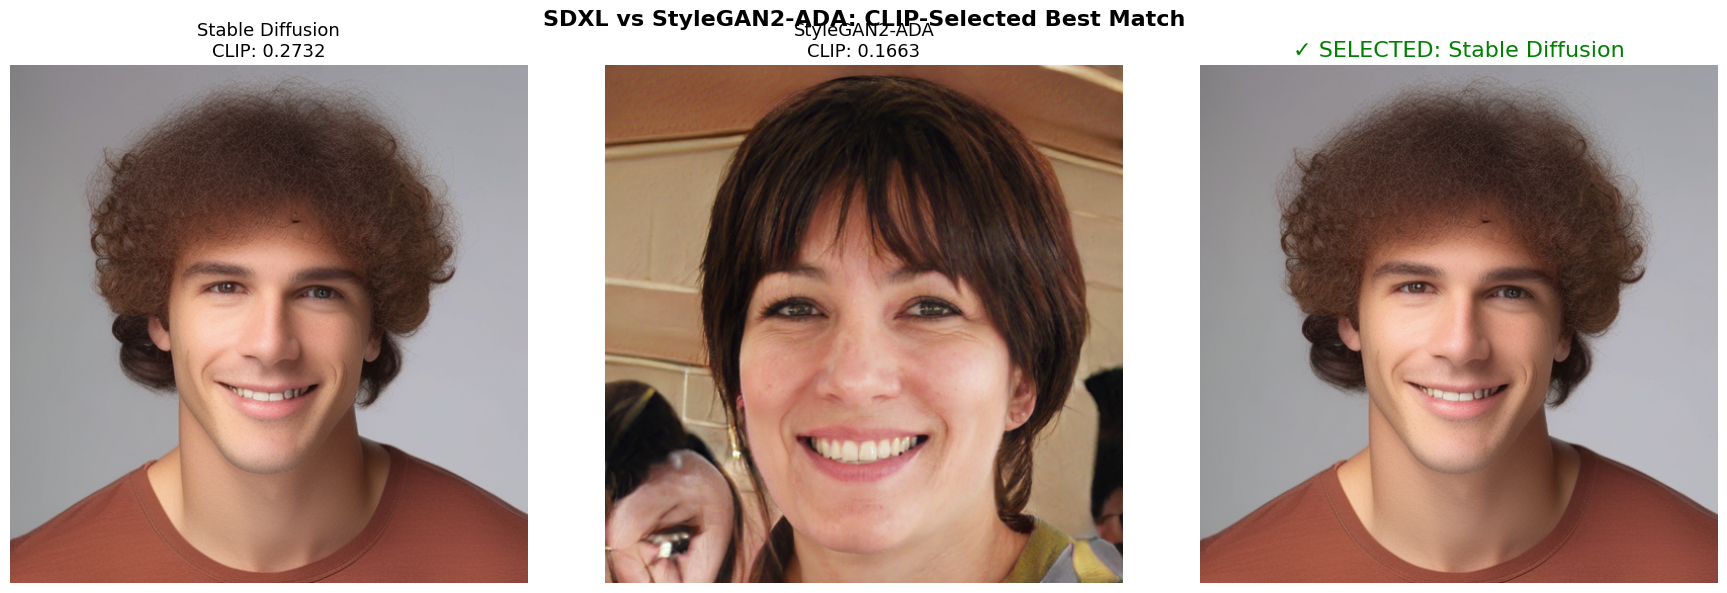

✓ Comparison plot saved: /kaggle/working/gan_vs_sd_vs_clip.png


In [28]:
# Ultimate Cell: SDXL + StyleGAN2-ADA + CLIP - Output best-matching face (Kaggle ready)
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import clip
import pickle
import os

torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- 1. Generate with Stable Diffusion XL -----
def generate_face_sdxl(prompt):
    enhanced_prompt = (
        f"professional studio portrait photograph, {prompt}, even lighting, soft shadows, detailed facial features, "
        "realistic skin tone, natural colors, centered composition, high resolution, front-facing view"
    )
    generator = torch.Generator(device).manual_seed(123)
    image = sd_pipe(
        prompt=enhanced_prompt,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=8.0,
        negative_prompt=(
            "black and white, monochrome, grayscale, blurry, cartoon, abstract, deformed, ugly, "
            "bad anatomy, harsh shadows, uneven lighting, dark face, half face in shadow, overexposed, underexposed, low quality"
        ),
        generator=generator
    ).images[0]
    return image

# ----- 2. Generate with StyleGAN2-ADA -----
def generate_face_stylegan2(ffhq_pkl_path, seed=123):
    with open(ffhq_pkl_path, 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(torch.float32).cuda()
    img = G(z, None, truncation_psi=0.7)
    img = (img.permute(0, 2, 3, 1).cpu().numpy()[0] * 127.5 + 128).clip(0, 255).astype(np.uint8)
    stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))
    return stylegan_image

# ----- 3. CLIP Scoring -----
def clip_score(image, text_prompt, preprocess, clip_model, device):
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([text_prompt]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).item()
    return similarity

# ----- 4. Generate and Select Best Image -----
print("\n" + "="*60)
print("GENERATING FINAL FACE: SDXL vs StyleGAN2-ADA with CLIP match")
user_prompt = "portrait photo of a man with brown curly hair"

print("\n[1] SDXL Generation...")
sd_image = generate_face_sdxl(user_prompt)
print("[2] StyleGAN2-ADA Generation...")
ffhq_pkl_path = "/kaggle/working/stylegan2-ada-pytorch/ffhq.pkl"  # Adjust if needed
sgan_image = generate_face_stylegan2(ffhq_pkl_path, seed=456)

print("[3] CLIP Model Loading & Scoring...")
clip_model, preprocess = clip.load("ViT-L/14", device=device)
sd_score = clip_score(sd_image, user_prompt, preprocess, clip_model, device)
sgan_score = clip_score(sgan_image, user_prompt, preprocess, clip_model, device)

print(f"\nStable Diffusion CLIP Score: {sd_score:.4f}")
print(f"StyleGAN2-ADA CLIP Score: {sgan_score:.4f}")

if sd_score > sgan_score:
    selected_image = sd_image
    method = "Stable Diffusion"
else:
    selected_image = sgan_image
    method = "StyleGAN2-ADA"

# ----- 5. Save final face and show comparison -----
out_dir = "/kaggle/working/"
if not os.path.exists(out_dir): os.makedirs(out_dir)
selected_path = os.path.join(out_dir, "final_best_face.png")
selected_image.save(selected_path)
print(f"\n✓ Final selected face (BEST MATCH): {selected_path}")

# (optional) Save comparison for documentation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(sd_image)
axes[0].set_title(f"Stable Diffusion\nCLIP: {sd_score:.4f}", fontsize=13)
axes[0].axis('off')
axes[1].imshow(sgan_image)
axes[1].set_title(f"StyleGAN2-ADA\nCLIP: {sgan_score:.4f}", fontsize=13)
axes[1].axis('off')
axes[2].imshow(selected_image)
axes[2].set_title(f"✓ SELECTED: {method}", color="green", fontsize=16)
axes[2].axis('off')
plt.suptitle("SDXL vs StyleGAN2-ADA: CLIP-Selected Best Match", fontsize=16, fontweight='bold')
plt.tight_layout()
comp_path = os.path.join(out_dir, "gan_vs_sd_vs_clip.png")
plt.savefig(comp_path, dpi=150)
plt.show()
print(f"✓ Comparison plot saved: {comp_path}")
print("="*60)



GENERATING FINAL FACE: SDXL vs StyleGAN2-ADA with CLIP match

[1] SDXL Generation...


  0%|          | 0/50 [00:00<?, ?it/s]

[2] StyleGAN2-ADA Generation...


/tmp/ipykernel_164/3764052352.py:41: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))


[3] CLIP Model Loading & Scoring...

Stable Diffusion CLIP Score: 0.2712
StyleGAN2-ADA CLIP Score: 0.1582

✓ Final selected face (BEST MATCH): /kaggle/working/final_best_face.png


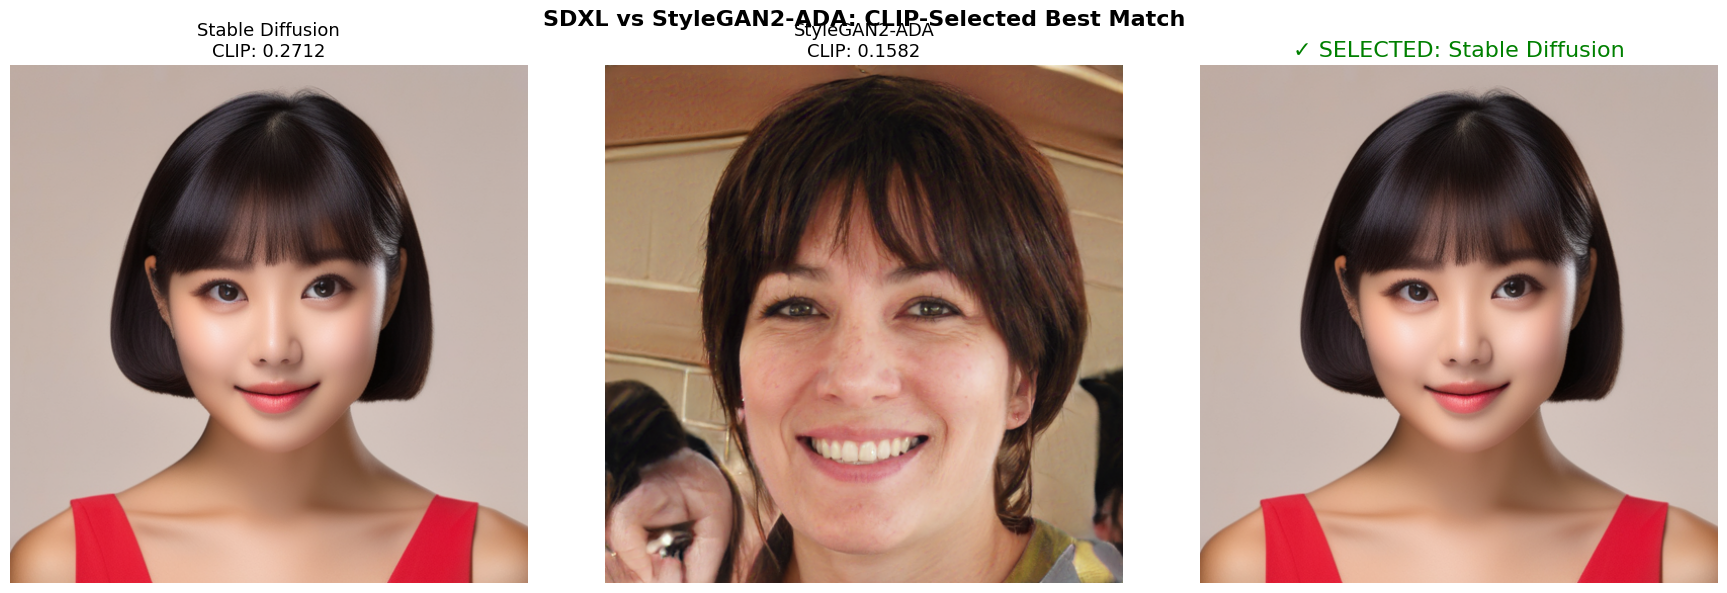

✓ Comparison plot saved: /kaggle/working/gan_vs_sd_vs_clip.png


In [29]:
# Ultimate Cell: SDXL + StyleGAN2-ADA + CLIP - Output best-matching face (Kaggle ready)
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import clip
import pickle
import os

torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- 1. Generate with Stable Diffusion XL -----
def generate_face_sdxl(prompt):
    enhanced_prompt = (
        f"professional studio portrait photograph, {prompt}, even lighting, soft shadows, detailed facial features, "
        "realistic skin tone, natural colors, centered composition, high resolution, front-facing view"
    )
    generator = torch.Generator(device).manual_seed(123)
    image = sd_pipe(
        prompt=enhanced_prompt,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=8.0,
        negative_prompt=(
            "black and white, monochrome, grayscale, blurry, cartoon, abstract, deformed, ugly, "
            "bad anatomy, harsh shadows, uneven lighting, dark face, half face in shadow, overexposed, underexposed, low quality"
        ),
        generator=generator
    ).images[0]
    return image

# ----- 2. Generate with StyleGAN2-ADA -----
def generate_face_stylegan2(ffhq_pkl_path, seed=123):
    with open(ffhq_pkl_path, 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(torch.float32).cuda()
    img = G(z, None, truncation_psi=0.7)
    img = (img.permute(0, 2, 3, 1).cpu().numpy()[0] * 127.5 + 128).clip(0, 255).astype(np.uint8)
    stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))
    return stylegan_image

# ----- 3. CLIP Scoring -----
def clip_score(image, text_prompt, preprocess, clip_model, device):
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([text_prompt]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).item()
    return similarity

# ----- 4. Generate and Select Best Image -----
print("\n" + "="*60)
print("GENERATING FINAL FACE: SDXL vs StyleGAN2-ADA with CLIP match")
user_prompt = "portrait photo of a girl with tanned skin colour, black silky hair, small nose, small ears, big lips and round face shape"

print("\n[1] SDXL Generation...")
sd_image = generate_face_sdxl(user_prompt)
print("[2] StyleGAN2-ADA Generation...")
ffhq_pkl_path = "/kaggle/working/stylegan2-ada-pytorch/ffhq.pkl"  # Adjust if needed
sgan_image = generate_face_stylegan2(ffhq_pkl_path, seed=456)

print("[3] CLIP Model Loading & Scoring...")
clip_model, preprocess = clip.load("ViT-L/14", device=device)
sd_score = clip_score(sd_image, user_prompt, preprocess, clip_model, device)
sgan_score = clip_score(sgan_image, user_prompt, preprocess, clip_model, device)

print(f"\nStable Diffusion CLIP Score: {sd_score:.4f}")
print(f"StyleGAN2-ADA CLIP Score: {sgan_score:.4f}")

if sd_score > sgan_score:
    selected_image = sd_image
    method = "Stable Diffusion"
else:
    selected_image = sgan_image
    method = "StyleGAN2-ADA"

# ----- 5. Save final face and show comparison -----
out_dir = "/kaggle/working/"
if not os.path.exists(out_dir): os.makedirs(out_dir)
selected_path = os.path.join(out_dir, "final_best_face.png")
selected_image.save(selected_path)
print(f"\n✓ Final selected face (BEST MATCH): {selected_path}")

# (optional) Save comparison for documentation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(sd_image)
axes[0].set_title(f"Stable Diffusion\nCLIP: {sd_score:.4f}", fontsize=13)
axes[0].axis('off')
axes[1].imshow(sgan_image)
axes[1].set_title(f"StyleGAN2-ADA\nCLIP: {sgan_score:.4f}", fontsize=13)
axes[1].axis('off')
axes[2].imshow(selected_image)
axes[2].set_title(f"✓ SELECTED: {method}", color="green", fontsize=16)
axes[2].axis('off')
plt.suptitle("SDXL vs StyleGAN2-ADA: CLIP-Selected Best Match", fontsize=16, fontweight='bold')
plt.tight_layout()
comp_path = os.path.join(out_dir, "gan_vs_sd_vs_clip.png")
plt.savefig(comp_path, dpi=150)
plt.show()
print(f"✓ Comparison plot saved: {comp_path}")
print("="*60)


Face Generation (SDXL + StyleGAN2-ADA + CLIP) - Single Best Output


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_164/1385868765.py:40: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))


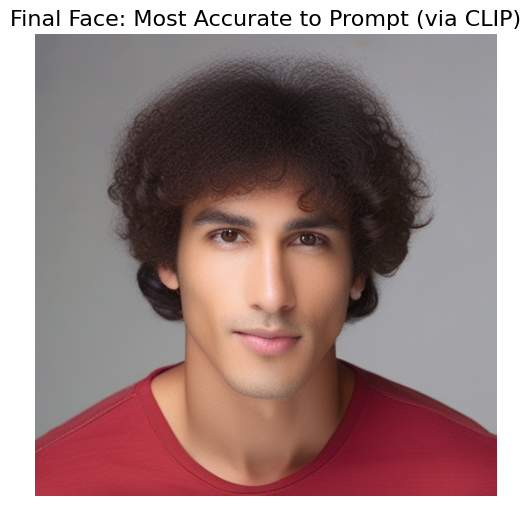

Final face image saved at: /kaggle/working/final_best_face.png


In [30]:
import torch
import numpy as np
from PIL import Image
import clip
import pickle
import os
import matplotlib.pyplot as plt

torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Stable Diffusion XL (SDXL) Generation ---
def generate_face_sdxl(prompt):
    enhanced_prompt = (
        f"professional studio portrait photograph, {prompt}, even lighting, soft shadows, detailed facial features, "
        "realistic skin tone, natural colors, centered composition, high resolution, front-facing view"
    )
    generator = torch.Generator(device).manual_seed(123)
    image = sd_pipe(
        prompt=enhanced_prompt,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=8.0,
        negative_prompt=(
            "black and white, monochrome, grayscale, blurry, cartoon, abstract, deformed, ugly, bad anatomy, "
            "harsh shadows, uneven lighting, dark face, half face in shadow, overexposed, underexposed, low quality"
        ),
        generator=generator
    ).images[0]
    return image

# --- StyleGAN2-ADA Generation ---
def generate_face_stylegan2(ffhq_pkl_path, seed=123):
    with open(ffhq_pkl_path, 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(torch.float32).cuda()
    img = G(z, None, truncation_psi=0.7)
    img = (img.permute(0, 2, 3, 1).cpu().numpy()[0] * 127.5 + 128).clip(0, 255).astype(np.uint8)
    stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))
    return stylegan_image

# --- CLIP Scoring ---
def clip_score(image, text_prompt, preprocess, clip_model, device):
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([text_prompt]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).item()
    return similarity

# --- Main Workflow ---
print("=" * 60)
print("Face Generation (SDXL + StyleGAN2-ADA + CLIP) - Single Best Output")
user_prompt = "portrait photo of a man with black curly hair, sharp nose, thin lips"

# 1. SDXL
sd_image = generate_face_sdxl(user_prompt)
# 2. StyleGAN2-ADA
ffhq_pkl_path = "/kaggle/working/stylegan2-ada-pytorch/ffhq.pkl"
sgan_image = generate_face_stylegan2(ffhq_pkl_path, seed=456)

# 3. CLIP model and scoring
clip_model, preprocess = clip.load("ViT-L/14", device=device)
sd_score = clip_score(sd_image, user_prompt, preprocess, clip_model, device)
sgan_score = clip_score(sgan_image, user_prompt, preprocess, clip_model, device)

# 4. Choose strictly the more accurate image and show/save it
final_image = sd_image if sd_score > sgan_score else sgan_image

out_dir = "/kaggle/working/"
os.makedirs(out_dir, exist_ok=True)
selected_path = os.path.join(out_dir, "final_best_face.png")
final_image.save(selected_path)

# --- VISUAL OUTPUT: Show ONLY the chosen image in the notebook ---
plt.figure(figsize=(6,6))
plt.imshow(final_image)
plt.axis('off')
plt.title("Final Face: Most Accurate to Prompt (via CLIP)", fontsize=16)
plt.show()
print(f"Final face image saved at: {selected_path}")
print("=" * 60)


Face Generation (SDXL + StyleGAN2-ADA + CLIP) - Single Best Output


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_164/2794560979.py:40: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))


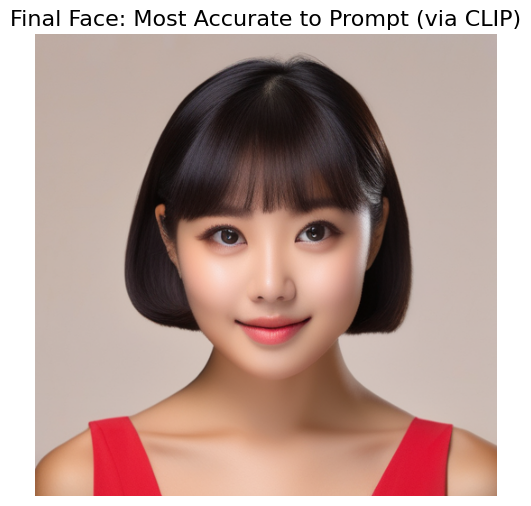

Final face image saved at: /kaggle/working/final_best_face.png


In [31]:
import torch
import numpy as np
from PIL import Image
import clip
import pickle
import os
import matplotlib.pyplot as plt

torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Stable Diffusion XL (SDXL) Generation ---
def generate_face_sdxl(prompt):
    enhanced_prompt = (
        f"professional studio portrait photograph, {prompt}, even lighting, soft shadows, detailed facial features, "
        "realistic skin tone, natural colors, centered composition, high resolution, front-facing view"
    )
    generator = torch.Generator(device).manual_seed(123)
    image = sd_pipe(
        prompt=enhanced_prompt,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=8.0,
        negative_prompt=(
            "black and white, monochrome, grayscale, blurry, cartoon, abstract, deformed, ugly, bad anatomy, "
            "harsh shadows, uneven lighting, dark face, half face in shadow, overexposed, underexposed, low quality"
        ),
        generator=generator
    ).images[0]
    return image

# --- StyleGAN2-ADA Generation ---
def generate_face_stylegan2(ffhq_pkl_path, seed=123):
    with open(ffhq_pkl_path, 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(torch.float32).cuda()
    img = G(z, None, truncation_psi=0.7)
    img = (img.permute(0, 2, 3, 1).cpu().numpy()[0] * 127.5 + 128).clip(0, 255).astype(np.uint8)
    stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))
    return stylegan_image

# --- CLIP Scoring ---
def clip_score(image, text_prompt, preprocess, clip_model, device):
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([text_prompt]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).item()
    return similarity

# --- Main Workflow ---
print("=" * 60)
print("Face Generation (SDXL + StyleGAN2-ADA + CLIP) - Single Best Output")
user_prompt = "portrait photo of a girl with tanned skin colour, black silky hair, small nose, small ears, big lips and round face shape"

# 1. SDXL
sd_image = generate_face_sdxl(user_prompt)
# 2. StyleGAN2-ADA
ffhq_pkl_path = "/kaggle/working/stylegan2-ada-pytorch/ffhq.pkl"
sgan_image = generate_face_stylegan2(ffhq_pkl_path, seed=456)

# 3. CLIP model and scoring
clip_model, preprocess = clip.load("ViT-L/14", device=device)
sd_score = clip_score(sd_image, user_prompt, preprocess, clip_model, device)
sgan_score = clip_score(sgan_image, user_prompt, preprocess, clip_model, device)

# 4. Choose strictly the more accurate image and show/save it
final_image = sd_image if sd_score > sgan_score else sgan_image

out_dir = "/kaggle/working/"
os.makedirs(out_dir, exist_ok=True)
selected_path = os.path.join(out_dir, "final_best_face.png")
final_image.save(selected_path)

# --- VISUAL OUTPUT: Show ONLY the chosen image in the notebook ---
plt.figure(figsize=(6,6))
plt.imshow(final_image)
plt.axis('off')
plt.title("Final Face: Most Accurate to Prompt (via CLIP)", fontsize=16)
plt.show()
print(f"Final face image saved at: {selected_path}")
print("=" * 60)


In [32]:
import gradio as gr
from PIL import Image
import numpy as np
import os
import time
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model once globally
clip_model, preprocess = clip.load("ViT-L/14", device=device)

def clip_score(image, prompt):
    try:
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        img_input = preprocess(image).unsqueeze(0).to(device)
        text_input = clip.tokenize([prompt]).to(device)
        with torch.no_grad():
            img_features = clip_model.encode_image(img_input)
            txt_features = clip_model.encode_text(text_input)
            img_features /= img_features.norm(dim=-1, keepdim=True)
            txt_features /= txt_features.norm(dim=-1, keepdim=True)
            return (img_features @ txt_features.T).item()
    except Exception as e:
        return None

# Disable NSFW filter globally (assumes inpaint_pipe exists)
inpaint_pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

os.makedirs('/kaggle/working/outputs', exist_ok=True)

# Use existing image for editing base
try:
    test = selected_image
except:
    try:
        selected_image = variations[2]
    except:
        raise Exception("❌ Please run Cell 9B first to generate base images!")

selected_image_np = np.array(selected_image.resize((512, 512)))

black_overlay = np.zeros_like(selected_image_np)
overlay_image = (selected_image_np * 0.5 + black_overlay * 0.5).astype(np.uint8)

# Inpainting function with integrated CLIP scoring
def ai_inpainting_mode(input_dict, edit_prompt):
    try:
        if not edit_prompt or edit_prompt.strip() == "":
            return None, "❌ Please enter what you want to add/change"

        if isinstance(input_dict, dict):
            background = input_dict.get("background")
            layers = input_dict.get("layers", [])

            if background is None:
                return None, "❌ No image provided"

            original_image = selected_image.copy().resize((512, 512))

            if layers and len(layers) > 0:
                drawn_layer = layers[0]
                if isinstance(drawn_layer, np.ndarray):
                    if drawn_layer.shape[-1] == 4:
                        mask_array = (drawn_layer[:, :, 3] > 0).astype(np.uint8) * 255
                    else:
                        mask_array = (np.any(drawn_layer > 0, axis=-1)).astype(np.uint8) * 255
                    mask = Image.fromarray(mask_array).convert("L")
                else:
                    return original_image, "❌ No mask drawn"
            else:
                return original_image, "❌ Draw on the image first"
        else:
            return None, "❌ Invalid input"

        mask_array = np.array(mask)
        mask_coverage = (mask_array > 128).sum() / mask_array.size
        if mask_coverage < 0.0002:
            return original_image, "❌ Mask too small - draw larger area"

        enhanced_prompt = f"{edit_prompt}, highly detailed, realistic, photorealistic, high quality"
        negative_prompt = "blurry, low quality, cartoon, anime, painting, sketch, unrealistic, distorted"

        start_time = time.time()

        result = inpaint_pipe(
            prompt=enhanced_prompt,
            image=original_image,
            mask_image=mask,
            num_inference_steps=50,
            guidance_scale=12.0,
            strength=1.0,
            negative_prompt=negative_prompt
        ).images[0]

        elapsed = time.time() - start_time

        timestamp = int(time.time())
        output_path = f'/kaggle/working/outputs/ai_inpainted_{timestamp}.png'
        mask_path = f'/kaggle/working/outputs/mask_{timestamp}.png'
        result.save(output_path)
        mask.save(mask_path)

        # Compute CLIP similarity score for inpainted image
        score = clip_score(result, edit_prompt)
        score_text = f"CLIP similarity score: {score:.4f}" if score is not None else "CLIP score unavailable"

        status = (
            f"✅ Complete! ({elapsed:.1f}s)\n"
            f"📁 Image: {output_path}\n"
            f"🎭 Mask: {mask_path}\n"
            f"📊 Coverage: {mask_coverage * 100:.3f}%\n"
            f"🔎 {score_text}"
        )

        return result, status

    except Exception as e:
        import traceback
        return None, f"❌ Error: {str(e)}\n{traceback.format_exc()}"

def manual_drawing_mode(input_dict):
    try:
        if isinstance(input_dict, dict):
            composite = input_dict.get("composite")
            if composite is None:
                return None, "❌ No drawing detected"
            if isinstance(composite, np.ndarray):
                result_image = Image.fromarray(composite).convert("RGB")
            else:
                result_image = composite.convert("RGB")
            timestamp = int(time.time())
            output_path = f'/kaggle/working/outputs/manual_drawn_{timestamp}.png'
            result_image.save(output_path)
            status = f"✅ Saved!\n📁 {output_path}"
            return result_image, status
    except Exception as e:
        return None, f"❌ Error: {str(e)}"

# Function to continue editing last inpainted result
from glob import glob
def continue_editing():
    saved_images = sorted(glob('/kaggle/working/outputs/ai_inpainted_*.png'), reverse=True)
    if not saved_images:
        return gr.Image.update(value=None), None, "", "❌ No inpainted image found to continue editing."
    last_img = Image.open(saved_images[0]).convert("RGB").resize((512, 512))
    blank_mask = np.zeros((512, 512, 3), dtype=np.uint8)
    return np.array(last_img), blank_mask, "", "📝 Loaded last inpainted image for continued editing."

with gr.Blocks(title="Criminal Face Editor", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🎨 Criminal Face Editor - High Accuracy")
    gr.Markdown("### AI Inpainting (50 steps, guidance=12) + Manual Drawing")
    
    gr.Markdown("---")

    with gr.Tab("🤖 AI Inpainting"):
        gr.Markdown("""
        ### Add ANY facial feature with maximum accuracy:
        
        **Supported features:**
        - Scars, cuts, wounds, injuries
        - Moles, birthmarks, freckles, beauty marks
        - Wrinkles, age lines, crow's feet
        - Tattoos, tribal marks, body art
        - Piercings (nose, eyebrow, lip, ear)
        - Facial hair (beard, mustache, sideburns, eyebrows)
        - Glasses, sunglasses, eyewear
        - Bruises, black eyes, discoloration
        - Acne, pockmarks, skin texture
        - ANY other facial feature you describe!
        
        **How to use:**
        1. **Draw small WHITE marks** on semi-transparent overlay (face visible underneath)
        2. **Be very specific** in your prompt (location, size, color, type)
        3. **Adjust brush size** with slider (start small, increase if needed)
        4. **Click Generate** and wait ~15-18 seconds (high quality mode)
        """)
        
        with gr.Row():
            with gr.Column():
                gr.Markdown("#### 🖼️ Draw Mask on Overlay")
                
                brush_size = gr.Slider(
                    minimum=3,
                    maximum=50,
                    value=8,
                    step=1,
                    label="Brush Size (3=pencil, 50=large)",
                    interactive=True
                )
                
                ai_editor = gr.ImageEditor(
                    value=overlay_image,
                    label="Draw WHITE on area to edit (face visible through overlay)",
                    type="numpy",
                    brush=gr.Brush(colors=["#FFFFFF"], default_size=8),
                    height=512
                )
                
                gr.Markdown("#### ✍️ Describe Feature (Be Specific!)")
                ai_prompt = gr.Textbox(
                    label="What to add/change?", 
                    placeholder="Good examples:\n- 'long vertical scar from left eyebrow to cheek'\n- 'small round black mole on right cheek near nose'\n- 'thick full gray beard and mustache'\n- 'thin rectangular black-framed glasses'\n- 'deep forehead wrinkles horizontal lines'\n- 'small silver stud nose piercing on left nostril'",
                    lines=4
                )
                
                ai_btn = gr.Button("🎨 Generate with AI (High Accuracy)", variant="primary", size="lg")
                continue_edit_btn = gr.Button("🖌️ Continue Editing Last Result")
                
                gr.Markdown("⏱️ **Generation time:** ~15-18 seconds")
                gr.Markdown("⚙️ **Settings:** 50 steps, guidance=12, strength=1.0 (maximum)")
                gr.Markdown("⚠️ **Note:** Black overlay is ONLY for marking - final image is clear!")
               
            with gr.Column():
                gr.Markdown("#### ✨ AI Result (Clear Image)")
                ai_output = gr.Image(label="Generated (no overlay!)", height=512)
                ai_status = gr.Textbox(label="Status & Info", lines=5, interactive=False)
        
        brush_size.change(
            fn=lambda size: gr.Brush(colors=["#FFFFFF"], default_size=int(size)),
            inputs=[brush_size],
            outputs=[]
        )
        
        ai_btn.click(
            fn=ai_inpainting_mode,
            inputs=[ai_editor, ai_prompt],
            outputs=[ai_output, ai_status]
        )
        
        continue_edit_btn.click(
            fn=continue_editing,
            inputs=[],
            outputs=[ai_editor, gr.State(), ai_prompt, ai_status]
        )
    
    with gr.Tab("✏️ Manual Drawing"):
        gr.Markdown("""
        ### Draw freehand directly on face:
        - No AI processing
        - Multiple colors available
        - Eraser tool included
        - Instant save
        - Good for: annotations, custom marks, sketches
        """)

        with gr.Row():
            with gr.Column():
                gr.Markdown("#### 🖌️ Draw on Face")
                
                manual_brush_size = gr.Slider(
                    minimum=2,
                    maximum=50,
                    value=5,
                    step=1,
                    label="Brush Size (2=fine, 50=thick)"
                )
                
                manual_editor = gr.ImageEditor(
                    value=selected_image_np,
                    label="Draw directly (clear image, no overlay)",
                    type="numpy",
                    brush=gr.Brush(colors=["#000000", "#FF0000", "#0000FF", "#00FF00", "#FFFF00", "#FFFFFF", "#FF00FF"], default_size=5),
                    eraser=gr.Eraser(default_size=10),
                    height=512
                )
                
                manual_btn = gr.Button("💾 Save Drawing", variant="primary", size="lg")
                
                gr.Markdown("✏️ **Colors:** Black, Red, Blue, Green, Yellow, White, Pink")
                
            with gr.Column():
                gr.Markdown("#### 💾 Saved Drawing")
                manual_output = gr.Image(label="Your Drawing", height=512)
                manual_status = gr.Textbox(label="Status", lines=3, interactive=False)

        manual_btn.click(
            fn=manual_drawing_mode,
            inputs=[manual_editor],
            outputs=[manual_output, manual_status]
        )
    
    gr.Markdown("---")
    gr.Markdown("### 💾 **All outputs auto-saved to:** `/kaggle/working/outputs/`")
    gr.Markdown("### 📊 **Files:** `ai_inpainted_*.png` (result + mask) | `manual_drawn_*.png`")

print("\n" + "=" * 60)
print("HIGH-ACCURACY DUAL-MODE FACE EDITOR")
print("=" * 60)
print("✓ NSFW filter: DISABLED")
print("✓ AI Inpainting: Uses ORIGINAL image (no overlay in result)")
print("✓ Brush: Pencil-small default, adjustable 3-50")
print("✓ Quality: 50 steps, guidance=12 (maximum accuracy)")
print("✓ GPU optimized for Kaggle")
print("=" * 60 + "\n")

demo.launch(share=True, debug=True)



HIGH-ACCURACY DUAL-MODE FACE EDITOR
✓ NSFW filter: DISABLED
✓ AI Inpainting: Uses ORIGINAL image (no overlay in result)
✓ Brush: Pencil-small default, adjustable 3-50
✓ Quality: 50 steps, guidance=12 (maximum accuracy)
✓ GPU optimized for Kaggle

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://083d84ba6fa582f969.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://083d84ba6fa582f969.gradio.live


In [33]:
import gradio as gr
from PIL import Image
import numpy as np
import os
import time
import clip
import torch
import pickle
import matplotlib.pyplot as plt
from glob import glob

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP once
clip_model, preprocess = clip.load("ViT-L/14", device=device)

# Assumes sd_pipe and inpaint_pipe are preloaded pipelines (load accordingly)
# Example:
# sd_pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0").to(device)
# inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting").to(device)
# Load StyleGAN2 checkpoint path:
ffhq_pkl_path = "/kaggle/working/stylegan2-ada-pytorch/ffhq.pkl"

def clip_score(image, prompt):
    try:
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        img_input = preprocess(image).unsqueeze(0).to(device)
        text_input = clip.tokenize([prompt]).to(device)
        with torch.no_grad():
            img_features = clip_model.encode_image(img_input)
            txt_features = clip_model.encode_text(text_input)
            img_features /= img_features.norm(dim=-1, keepdim=True)
            txt_features /= txt_features.norm(dim=-1, keepdim=True)
            return (img_features @ txt_features.T).item()
    except Exception:
        return None

def generate_face_sdxl(prompt):
    enhanced_prompt = (
        f"professional studio portrait photograph, {prompt}, even lighting, soft shadows, detailed facial features, "
        "realistic skin tone, natural colors, centered composition, high resolution, front-facing view"
    )
    generator = torch.Generator(device).manual_seed(123)
    image = sd_pipe(
        prompt=enhanced_prompt,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=8.0,
        negative_prompt=(
            "black and white, monochrome, grayscale, blurry, cartoon, abstract, deformed, ugly, bad anatomy, "
            "harsh shadows, uneven lighting, dark face, half face in shadow, overexposed, underexposed, low quality"
        ),
        generator=generator
    ).images[0]
    return image

def generate_face_stylegan2(ffhq_pkl_path, seed=123):
    with open(ffhq_pkl_path, 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(torch.float32).cuda()
    img = G(z, None, truncation_psi=0.7)
    img = (img.permute(0, 2, 3, 1).cpu().numpy()[0] * 127.5 + 128).clip(0, 255).astype(np.uint8)
    stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))
    return stylegan_image

def face_generation_pipeline(prompt):
    sd_image = generate_face_sdxl(prompt)
    sgan_image = generate_face_stylegan2(ffhq_pkl_path, seed=456)
    sd_score = clip_score(sd_image, prompt)
    sgan_score = clip_score(sgan_image, prompt)
    selected_img = sd_image if sd_score > sgan_score else sgan_image
    return selected_img, f"Stable Diffusion CLIP score: {sd_score:.3f}\nStyleGAN2-ADA CLIP score: {sgan_score:.3f}"

def ai_inpainting_mode(input_dict, edit_prompt):
    try:
        if not edit_prompt or edit_prompt.strip() == "":
            return None, "❌ Please enter what you want to add/change"

        if isinstance(input_dict, dict):
            layers = input_dict.get("layers", [])
            if input_dict.get("background") is None:
                return None, "❌ No image provided"
            original_image = selected_image.copy().resize((512, 512))
            if layers and len(layers) > 0:
                drawn_layer = layers[0]
                if isinstance(drawn_layer, np.ndarray):
                    if drawn_layer.shape[-1] == 4:  # RGBA
                        mask_array = (drawn_layer[:, :, 3] > 0).astype(np.uint8) * 255
                    else:  # RGB
                        mask_array = (np.any(drawn_layer > 0, axis=-1)).astype(np.uint8) * 255
                    mask = Image.fromarray(mask_array).convert("L")
                else:
                    return original_image, "❌ No mask drawn"
            else:
                return original_image, "❌ Draw on the image first"
        else:
            return None, "❌ Invalid input"

        mask_array = np.array(mask)
        mask_coverage = (mask_array > 128).sum() / mask_array.size
        if mask_coverage < 0.0002:
            return original_image, "❌ Mask too small - draw larger area"

        enhanced_prompt = f"{edit_prompt}, highly detailed, realistic, photorealistic, high quality"
        negative_prompt = "blurry, low quality, cartoon, anime, painting, sketch, unrealistic, distorted"

        start_time = time.time()

        result = inpaint_pipe(
            prompt=enhanced_prompt,
            image=original_image,
            mask_image=mask,
            num_inference_steps=50,
            guidance_scale=12.0,
            strength=1.0,
            negative_prompt=negative_prompt
        ).images[0]

        elapsed = time.time() - start_time

        timestamp = int(time.time())
        output_path = f'/kaggle/working/outputs/ai_inpainted_{timestamp}.png'
        mask_path = f'/kaggle/working/outputs/mask_{timestamp}.png'
        result.save(output_path)
        mask.save(mask_path)

        score = clip_score(result, edit_prompt)
        score_text = f"CLIP similarity score: {score:.4f}" if score is not None else "CLIP score unavailable"

        status = (
            f"✅ Complete! ({elapsed:.1f}s)\n"
            f"📁 Image: {output_path}\n"
            f"🎭 Mask: {mask_path}\n"
            f"📊 Coverage: {mask_coverage * 100:.3f}%\n"
            f"🔎 {score_text}"
        )

        return result, status

    except Exception as e:
        import traceback
        return None, f"❌ Error: {str(e)}\n{traceback.format_exc()}"

def manual_drawing_mode(input_dict):
    try:
        if isinstance(input_dict, dict):
            composite = input_dict.get("composite")
            if composite is None:
                return None, "❌ No drawing detected"
            if isinstance(composite, np.ndarray):
                result_image = Image.fromarray(composite).convert("RGB")
            else:
                result_image = composite.convert("RGB")
            timestamp = int(time.time())
            output_path = f'/kaggle/working/outputs/manual_drawn_{timestamp}.png'
            result_image.save(output_path)
            status = f"✅ Saved!\n📁 {output_path}"
            return result_image, status
    except Exception as e:
        return None, f"❌ Error: {str(e)}"

def continue_editing():
    saved_images = sorted(glob('/kaggle/working/outputs/ai_inpainted_*.png'), reverse=True)
    if not saved_images:
        return gr.Image.update(value=None), None, "", "❌ No inpainted image found to continue editing."
    last_img = Image.open(saved_images[0]).convert("RGB").resize((512, 512))
    blank_mask = np.zeros((512, 512, 3), dtype=np.uint8)
    return np.array(last_img), blank_mask, "", "📝 Loaded last inpainted image for continued editing."

# Prepare overlay image for drawing
selected_image = Image.new("RGB", (512, 512), (128,128,128))  # default blank or replace with initial if available
selected_image_np = np.array(selected_image)
black_overlay = np.zeros_like(selected_image_np)
overlay_image = (selected_image_np * 0.5 + black_overlay * 0.5).astype(np.uint8)

with gr.Blocks(title="Face Gen + Criminal Face Editor (AI + Manual)", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🚀 Face Generation + Criminal Face Editor")

    with gr.Row():
        with gr.Column(scale=3):
            gr.Markdown("## Step 1: Generate Face from Prompt")
            gen_prompt = gr.Textbox(label="Type face generation prompt", lines=2,
                                    placeholder="e.g., portrait photo of a middle-aged man with brown hair and glasses")
            gen_button = gr.Button("Generate Face")
            gen_output = gr.Image(label="Generated Face")

            status_gen = gr.Textbox(label="Generation status", interactive=False, lines=2)

        with gr.Column(scale=7):
            gr.Markdown("## Step 2: Edit Face with AI Inpainting")

            brush_size = gr.Slider(3, 50, 8, label="Brush Size (3=pencil, 50=large)", interactive=True)
            ai_editor = gr.ImageEditor(value=overlay_image, label="Draw WHITE mask on area to edit",
                                      type="numpy", brush=gr.Brush(colors=["#FFFFFF"], default_size=8), height=512)
            ai_prompt = gr.Textbox(
                label="Describe the feature to add/change", lines=4,
                placeholder="e.g., 'small scar on left cheek', 'thin black mustache', 'blue sunglasses'")

            ai_btn = gr.Button("🎨 Generate Edit with AI", variant="primary", size="lg")
            continue_edit_btn = gr.Button("🖌️ Continue Editing Last Result")
            
            ai_output = gr.Image(label="Edited Face Result", height=512)
            ai_status = gr.Textbox(label="Edit status & CLIP score", lines=6, interactive=False)

    # Connect generation button
    def gen_face_and_set_selected(p):
        img, status = face_generation_pipeline(p)
        global selected_image, overlay_image, selected_image_np
        if img:
            selected_image = img
            selected_image_np = np.array(selected_image.resize((512, 512)))
            black_overlay = np.zeros_like(selected_image_np)
            overlay_image = (selected_image_np * 0.5 + black_overlay * 0.5).astype(np.uint8)
        return img, status

    gen_button.click(gen_face_and_set_selected, inputs=gen_prompt, outputs=[gen_output, status_gen])

    # Connect brush size update (for brush size in ai_editor)
    brush_size.change(lambda size: gr.Brush(colors=["#FFFFFF"], default_size=int(size)), inputs=brush_size)

    # Connect AI Editing button
    ai_btn.click(ai_inpainting_mode, inputs=[ai_editor, ai_prompt], outputs=[ai_output, ai_status])

    # Connect continue editing button
    continue_edit_btn.click(continue_editing, inputs=[], outputs=[ai_editor, gr.State(), ai_prompt, ai_status])

demo.launch(share=True, debug=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b5710c6be08447f757.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_164/2185039844.py:65: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_164/2185039844.py:65: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_164/2185039844.py:65: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b5710c6be08447f757.gradio.live


In [35]:
import gradio as gr
from PIL import Image
import numpy as np
import os
import time
import clip
import torch
import pickle
from glob import glob

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP once
clip_model, preprocess = clip.load("ViT-L/14", device=device)

# Model loading (please load your pipelines as shown in comments)
# from diffusers import StableDiffusionXLPipeline, StableDiffusionInpaintPipeline
# sd_pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0").to(device)
# inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting").to(device)

ffhq_pkl_path = "/kaggle/working/stylegan2-ada-pytorch/ffhq.pkl"

def clip_score(image, prompt):
    try:
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        img_input = preprocess(image).unsqueeze(0).to(device)
        text_input = clip.tokenize([prompt]).to(device)
        with torch.no_grad():
            img_features = clip_model.encode_image(img_input)
            txt_features = clip_model.encode_text(text_input)
            img_features /= img_features.norm(dim=-1, keepdim=True)
            txt_features /= txt_features.norm(dim=-1, keepdim=True)
            return (img_features @ txt_features.T).item()
    except Exception:
        return None

def generate_face_sdxl(prompt):
    enhanced_prompt = (
        f"professional studio portrait photograph, {prompt}, even lighting, soft shadows, detailed facial features, "
        "realistic skin tone, natural colors, centered composition, high resolution, front-facing view"
    )
    generator = torch.Generator(device).manual_seed(123)
    image = sd_pipe(
        prompt=enhanced_prompt,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=8.0,
        negative_prompt=(
            "black and white, monochrome, grayscale, blurry, cartoon, abstract, deformed, ugly, bad anatomy, "
            "harsh shadows, uneven lighting, dark face, half face in shadow, overexposed, underexposed, low quality"
        ),
        generator=generator
    ).images[0]
    return image

def generate_face_stylegan2(ffhq_pkl_path, seed=123):
    with open(ffhq_pkl_path, 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(torch.float32).cuda()
    img = G(z, None, truncation_psi=0.7)
    img = (img.permute(0, 2, 3, 1).cpu().numpy()[0] * 127.5 + 128).clip(0, 255).astype(np.uint8)
    stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))
    return stylegan_image

def face_generation_pipeline(prompt):
    sd_image = generate_face_sdxl(prompt)
    sgan_image = generate_face_stylegan2(ffhq_pkl_path, seed=456)
    sd_score = clip_score(sd_image, prompt)
    sgan_score = clip_score(sgan_image, prompt)
    selected_img = sd_image if sd_score > sgan_score else sgan_image
    status = f"Stable Diffusion CLIP score: {sd_score:.3f}\nStyleGAN2-ADA CLIP score: {sgan_score:.3f}"
    overlay_img = to_overlay_np(selected_img)
    return selected_img, status, selected_img, overlay_img

def ai_inpainting_mode(selected_image, input_dict, edit_prompt):
    try:
        if not edit_prompt or edit_prompt.strip() == "":
            return None, "❌ Please enter what you want to add/change"

        if isinstance(input_dict, dict):
            layers = input_dict.get("layers", [])
            if input_dict.get("background") is None:
                return None, "❌ No image provided"
            original_image = selected_image.copy().resize((512, 512))
            if layers and len(layers) > 0:
                drawn_layer = layers[0]
                if isinstance(drawn_layer, np.ndarray):
                    if drawn_layer.shape[-1] == 4:  # RGBA
                        mask_array = (drawn_layer[:, :, 3] > 0).astype(np.uint8) * 255
                    else:
                        mask_array = (np.any(drawn_layer > 0, axis=-1)).astype(np.uint8) * 255
                    mask = Image.fromarray(mask_array).convert("L")
                else:
                    return original_image, "❌ No mask drawn"
            else:
                return original_image, "❌ Draw on the image first"
        else:
            return None, "❌ Invalid input"

        mask_array = np.array(mask)
        mask_coverage = (mask_array > 128).sum() / mask_array.size
        if mask_coverage < 0.0002:
            return original_image, "❌ Mask too small - draw larger area"

        enhanced_prompt = f"{edit_prompt}, highly detailed, realistic, photorealistic, high quality"
        negative_prompt = "blurry, low quality, cartoon, anime, painting, sketch, unrealistic, distorted"

        start_time = time.time()

        result = inpaint_pipe(
            prompt=enhanced_prompt,
            image=original_image,
            mask_image=mask,
            num_inference_steps=50,
            guidance_scale=12.0,
            strength=1.0,
            negative_prompt=negative_prompt
        ).images[0]

        elapsed = time.time() - start_time

        timestamp = int(time.time())
        output_path = f'/kaggle/working/outputs/ai_inpainted_{timestamp}.png'
        mask_path = f'/kaggle/working/outputs/mask_{timestamp}.png'
        result.save(output_path)
        mask.save(mask_path)

        score = clip_score(result, edit_prompt)
        score_text = f"CLIP similarity score: {score:.4f}" if score is not None else "CLIP score unavailable"

        status = (
            f"✅ Complete! ({elapsed:.1f}s)\n"
            f"📁 Image: {output_path}\n"
            f"🎭 Mask: {mask_path}\n"
            f"📊 Coverage: {mask_coverage * 100:.3f}%\n"
            f"🔎 {score_text}"
        )

        # For iterative edits, output new overlay for next mask
        overlay_img = to_overlay_np(result)
        return result, status, result, overlay_img

    except Exception as e:
        import traceback
        return None, f"❌ Error: {str(e)}\n{traceback.format_exc()}", None, None

def manual_drawing_mode(input_dict):
    try:
        if isinstance(input_dict, dict):
            composite = input_dict.get("composite")
            if composite is None:
                return None, "❌ No drawing detected"
            if isinstance(composite, np.ndarray):
                result_image = Image.fromarray(composite).convert("RGB")
            else:
                result_image = composite.convert("RGB")
            timestamp = int(time.time())
            output_path = f'/kaggle/working/outputs/manual_drawn_{timestamp}.png'
            result_image.save(output_path)
            status = f"✅ Saved!\n📁 {output_path}"
            return result_image, status
    except Exception as e:
        return None, f"❌ Error: {str(e)}"

def continue_editing():
    saved_images = sorted(glob('/kaggle/working/outputs/ai_inpainted_*.png'), reverse=True)
    if not saved_images:
        return gr.Image.update(value=None), None, "", "❌ No inpainted image found to continue editing."
    last_img = Image.open(saved_images[0]).convert("RGB").resize((512, 512))
    blank_mask = to_overlay_np(last_img)
    return blank_mask, last_img, "", "📝 Loaded last inpainted image for continued editing."

def to_overlay_np(img):
    np_img = np.array(img.resize((512,512)))
    black_overlay = np.zeros_like(np_img)
    overlay_input = (np_img * 0.5 + black_overlay * 0.5).astype(np.uint8)
    return overlay_input

default_image = Image.new("RGB", (512, 512), (128, 128, 128))

with gr.Blocks(title="Face Gen + Criminal Face Editor (AI + Manual)", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🚀 Face Generation + Criminal Face Editor")

    selected_image_state = gr.State(value=default_image)  # PIL
    ai_editor_image_state = gr.State(value=to_overlay_np(default_image))  # np.array

    with gr.Row():
        with gr.Column(scale=3):
            gr.Markdown("## Step 1: Generate Face from Prompt")
            gen_prompt = gr.Textbox(label="Type face generation prompt", lines=2,
                                    placeholder="e.g., portrait photo of a middle-aged man with brown hair and glasses")
            gen_button = gr.Button("Generate Face")
            gen_output = gr.Image(label="Generated Face")
            status_gen = gr.Textbox(label="Generation status", interactive=False, lines=2)

        with gr.Column(scale=7):
            gr.Markdown("## Step 2: Edit Face with AI Inpainting")
            brush_size = gr.Slider(3, 50, 8, label="Brush Size (3=pencil, 50=large)", interactive=True)
            ai_editor = gr.ImageEditor(value=to_overlay_np(default_image), label="Draw WHITE mask on area to edit",
                                      type="numpy", brush=gr.Brush(colors=["#FFFFFF"], default_size=8), height=512)
            ai_prompt = gr.Textbox(
                label="Describe the feature to add/change", lines=4,
                placeholder="e.g., 'small scar on left cheek', 'thin black mustache', 'blue sunglasses'")

            ai_btn = gr.Button("🎨 Generate Edit with AI", variant="primary", size="lg")
            continue_edit_btn = gr.Button("🖌️ Continue Editing Last Result")
            
            ai_output = gr.Image(label="Edited Face Result", height=512)
            ai_status = gr.Textbox(label="Edit status & CLIP score", lines=6, interactive=False)

    def gen_face_and_set_selected(p):
        img, status, pil_img, overlay_img = face_generation_pipeline(p)
        return img, status, pil_img, overlay_img

    gen_button.click(
        fn=gen_face_and_set_selected,
        inputs=gen_prompt,
        outputs=[gen_output, status_gen, selected_image_state, ai_editor]
    )

    brush_size.change(
        lambda size: gr.Brush(colors=["#FFFFFF"], default_size=int(size)),
        inputs=brush_size,
        outputs=[]
    )

    ai_btn.click(
        fn=ai_inpainting_mode,
        inputs=[selected_image_state, ai_editor, ai_prompt],
        outputs=[ai_output, ai_status, selected_image_state, ai_editor]
    )

    continue_edit_btn.click(
        fn=continue_editing,
        inputs=[],
        outputs=[ai_editor, selected_image_state, ai_prompt, ai_status]
    )

demo.launch(share=True, debug=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://931cfd7ad8611c29a2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_164/732424729.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  stylegan_image = Image.fromarray(img, 'RGB').resize((512, 512))


  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b3b674a0bd5d90e37e.gradio.live
Killing tunnel 127.0.0.1:7860 <> https://931cfd7ad8611c29a2.gradio.live
